# Random Forest algorithm that takes in El Nino, MJO, and hurricane climatology to make hurricane predictions weeks in advance. 

### by Zaibeth Carlo Frontera 
#### August 28, 2022 -- version \# ?

###### This code has portions from Libby's and Hareesh Bahuleyan's works on random forests.  

In [1]:
# Importing necessary libraries 

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
# import pydot
import seaborn as sns; #sns.set_theme()
import xarray as xr
import warnings

# To plot pretty figures directly within Jupyter

plt.style.use('default')
%matplotlib inline
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (7.0/2, 10.0/2) 

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

#### LOADING DATASETS: daily values from 1979 - 2019 

In [2]:
#Load datasets of the samples (labels) and predictions

# samples = pd.read_csv('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/phase_2/datasets/samples.csv').iloc[:,5:]


# clim = pd.read_csv('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/phase_2/datasets/samples.csv').iloc[:,10]

# predictions = pd.read_csv('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/phase_2/datasets/predictions_lead2week_2classes.csv').iloc[:,1:]


data = pd.read_csv('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/research/phase_4/datasets/predictor&predictants_79_19.csv').iloc[:,1:]

extra = pd.read_csv('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/research/phase_4/datasets/raw_climatology_79_20_2classes.csv').to_numpy()

 #### Print the sets to start to get a feeling of how the data looks

In [3]:
display(data)
print(max(extra))

,intensity,latitude,longitude,date,year2,dayinyear,genesis_index,mjo_phase,mjo_phase-1,mjo_amplitude,mjo_amplitude-1,RMM1,RMM1-1,RMM2,RMM2-1,enso_index,hurr_climatology
0,0.0,0.0,0.0,1979-05-15,1979.0,135.0,0.0,6.0,4.0,1.828850,1.002900,1.218280,0.867570,1.364000,-0.503120,-0.873668,0.096904
1,0.0,0.0,0.0,1979-05-16,1979.0,136.0,0.0,6.0,4.0,1.857140,1.126070,0.959488,0.874559,1.590080,-0.709350,-0.873668,0.109186
2,0.0,0.0,0.0,1979-05-17,1979.0,137.0,0.0,6.0,4.0,1.977830,0.857555,0.808853,0.764947,1.804870,-0.387630,-0.873668,0.121959
3,0.0,0.0,0.0,1979-05-18,1979.0,138.0,0.0,6.0,4.0,1.951280,0.842065,0.354324,0.832855,1.918840,-0.124200,-0.873668,0.135094
4,0.0,0.0,0.0,1979-05-19,1979.0,139.0,0.0,7.0,5.0,1.649500,0.840359,-0.007430,0.823702,1.649480,0.166488,-0.873668,0.148457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,0.0,0.0,0.0,2019-11-27,2019.0,331.0,0.0,8.0,8.0,0.514164,1.078690,-0.505107,-1.077624,0.096100,0.047900,4.010618,0.065546
8237,0.0,0.0,0.0,2019-11-28,2019.0,332.0,0.0,1.0,1.0,0.655423,1.023212,-0.647361,-0.884941,-0.102484,-0.513656,4.010618,0.062514
8238,0.0,0.0,0.0,2019-11-29,2019.0,333.0,0.0,1.0,2.0,0.788271,0.725788,-0.683537,-0.442011,-0.392617,-0.575668,4.010618,0.059266
8239,0.0,0.0,0.0,2019-11-30,2019.0,334.0,0.0,1.0,3.0,0.495922,0.511749,-0.406040,0.164058,-0.284727,-0.484739,4.010618,0.055807


[0.88945578]


#### Adding some columns with extra info

In [4]:
extra = extra[135:335]

In [5]:
extra_col = []

for e in range(0, 42): 
    extra_col.append(extra)
    
    
extra_col = (np.asarray(extra_col))

In [6]:
extra_col = (extra_col.flatten(order = 'C'))

data['raw_climatology'] = extra_col[:len(data)]

In [7]:
#adding a delta rmm columns
delta_rmm1 =  data['RMM1'] - data['RMM1-1']

delta_rmm2 = data['RMM2'] - data['RMM2-1']

In [8]:
data['delta_rmm1'] = delta_rmm1
data['delta_rmm2'] = delta_rmm2

display(data)

,intensity,latitude,longitude,date,year2,dayinyear,genesis_index,mjo_phase,mjo_phase-1,mjo_amplitude,mjo_amplitude-1,RMM1,RMM1-1,RMM2,RMM2-1,enso_index,hurr_climatology,raw_climatology,delta_rmm1,delta_rmm2
0,0.0,0.0,0.0,1979-05-15,1979.0,135.0,0.0,6.0,4.0,1.828850,1.002900,1.218280,0.867570,1.364000,-0.503120,-0.873668,0.096904,0.142857,0.350710,1.867120
1,0.0,0.0,0.0,1979-05-16,1979.0,136.0,0.0,6.0,4.0,1.857140,1.126070,0.959488,0.874559,1.590080,-0.709350,-0.873668,0.109186,0.155612,0.084929,2.299430
2,0.0,0.0,0.0,1979-05-17,1979.0,137.0,0.0,6.0,4.0,1.977830,0.857555,0.808853,0.764947,1.804870,-0.387630,-0.873668,0.121959,0.164966,0.043906,2.192500
3,0.0,0.0,0.0,1979-05-18,1979.0,138.0,0.0,6.0,4.0,1.951280,0.842065,0.354324,0.832855,1.918840,-0.124200,-0.873668,0.135094,0.170918,-0.478531,2.043040
4,0.0,0.0,0.0,1979-05-19,1979.0,139.0,0.0,7.0,5.0,1.649500,0.840359,-0.007430,0.823702,1.649480,0.166488,-0.873668,0.148457,0.173469,-0.831132,1.482992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236,0.0,0.0,0.0,2019-11-27,2019.0,331.0,0.0,8.0,8.0,0.514164,1.078690,-0.505107,-1.077624,0.096100,0.047900,4.010618,0.065546,0.513605,0.572518,0.048200
8237,0.0,0.0,0.0,2019-11-28,2019.0,332.0,0.0,1.0,1.0,0.655423,1.023212,-0.647361,-0.884941,-0.102484,-0.513656,4.010618,0.062514,0.498299,0.237580,0.411172
8238,0.0,0.0,0.0,2019-11-29,2019.0,333.0,0.0,1.0,2.0,0.788271,0.725788,-0.683537,-0.442011,-0.392617,-0.575668,4.010618,0.059266,0.477891,-0.241526,0.183051
8239,0.0,0.0,0.0,2019-11-30,2019.0,334.0,0.0,1.0,3.0,0.495922,0.511749,-0.406040,0.164058,-0.284727,-0.484739,4.010618,0.055807,0.458333,-0.570098,0.200012


#### Further look into the datasets

In [9]:
data.describe()

,intensity,latitude,longitude,year2,dayinyear,genesis_index,mjo_phase,mjo_phase-1,mjo_amplitude,mjo_amplitude-1,RMM1,RMM1-1,RMM2,RMM2-1,enso_index,hurr_climatology,raw_climatology,delta_rmm1,delta_rmm2
count,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000,8241.000000
mean,5.069166,0.906820,7.114367,1999.000000,235.000000,0.393347,4.237835,4.245601,1.177188,1.183083,-0.044806,-0.043238,-0.030803,-0.028970,0.173231,0.447612,0.450912,-0.001569,-0.001833
std,20.461634,3.424181,26.430169,11.832878,58.026505,0.412730,2.327439,2.327049,0.606138,0.606505,0.964339,0.970329,0.905779,0.907444,0.970974,0.203578,0.265262,1.023537,0.928291
min,0.000000,0.000000,0.000000,1979.000000,135.000000,0.000000,1.000000,1.000000,0.003290,0.003290,-3.151213,-3.151213,-2.668730,-2.668730,-2.197446,0.052160,0.017857,-4.038170,-3.082490
25%,0.000000,0.000000,0.000000,1989.000000,185.000000,0.000000,2.000000,2.000000,0.717826,0.721759,-0.699360,-0.705671,-0.654230,-0.658419,-0.508488,0.280008,0.171769,-0.692999,-0.640012
50%,0.000000,0.000000,0.000000,1999.000000,235.000000,0.285714,4.000000,4.000000,1.107143,1.114720,-0.058400,-0.058200,-0.082000,-0.076800,0.153402,0.531900,0.498299,0.024200,-0.018601
75%,0.000000,0.000000,0.000000,2009.000000,285.000000,0.857143,6.000000,6.000000,1.575570,1.583920,0.621611,0.621959,0.572976,0.578041,0.678348,0.626989,0.653061,0.726687,0.632730
max,185.000000,21.700000,119.900000,2019.000000,335.000000,1.000000,8.000000,8.000000,3.804237,3.804237,3.532000,3.532000,3.720131,3.720131,4.010618,0.672537,0.889456,3.159060,3.719570


In [10]:
# COMMENT THIS CELL IF ALL TROPICAL STORMS ARE NEEDED 

# UNCOMMENTED MEANS THAT ONLY HURRICANES ARE BEING USED 


# for d in range(len(data)):
#     if data['intensity'][d] <= 63:
#         data['genesis_index'][d] = 0 

#### Adding lag time and lead time (i.e., how many weeks in advance we will be forecasting) 

In [11]:
#Adding lag time

lead = 7 * 2

lag_rmm = 1

lag_sst = 7 * 4

# todos_x = todos #IF NOT LAGGING DATA

todos_x = pd.DataFrame({'storms_01':data['genesis_index'].iloc[:-(lead*2)], #creating dataframe where all the lagged data will be saved
                       })

todos_RMM1 = data['RMM1'].iloc[lag_rmm:-(lag_sst-lag_rmm)].reset_index(drop = True) #Cutting off at the beginning 
todos_RMM2 = data['RMM2'].iloc[lag_rmm:-(lag_sst-lag_rmm)].reset_index(drop = True) #Cutting off at the beginning 
todos_delta_RMM1 = data['delta_rmm1'].iloc[lag_rmm:-(lag_sst-lag_rmm)].reset_index(drop = True) #Cutting off at the beginning 
todos_delta_RMM2 = data['delta_rmm2'].iloc[lag_rmm:-(lag_sst-lag_rmm)].reset_index(drop = True) #Cutting off at the beginning 
todos_mjo_phase = data['mjo_phase'].iloc[lag_rmm:-(lag_sst-lag_rmm)].reset_index(drop = True)#Cutting off at the beginning 
todos_ENSO = data['enso_index'].iloc[lag_sst:].reset_index(drop = True)#Cutting off at the beginning 
todos_HURR = (data['hurr_climatology'].iloc[lead:-(lead)]).reset_index(drop = True)#Cutting off at the end
todos_RAW = (data['raw_climatology'].iloc[lead:-(lead)]).reset_index(drop = True)#Cutting off at the end  # CONFUSED, AGAIN. SHOULD DAY IN YEAR AND CLIM BE LAGGED TOO??
# todos_INT = (data['intensity'].iloc[lead:]).reset_index(drop = True)
# todos_GEN = data['genesis_index'].iloc[:-lag]
todos_DATE = data['date'].iloc[:-(lead)]
todos_DOY = data['dayinyear'].iloc[lead:-(lead)]
todos_year = data['year2'].iloc[:-(lead)]

In [12]:
#making they all have the same length 

todos_mjo_phase.shape, todos_ENSO.shape, todos_HURR.shape, todos_x.shape

((8213,), (8213,), (8213,), (8213, 1))

In [13]:
sum(todos_x['storms_01'])

3234.5714285714284

In [14]:
#Choosing which features will be fed into the random forest 

todos_x['RMM1'] = todos_RMM1
todos_x['RMM2'] = todos_RMM2
todos_x['delta_RMM1'] = todos_delta_RMM1
todos_x['delta_RMM2'] = todos_delta_RMM2
todos_x['mjo_phase'] = todos_mjo_phase 
todos_x['enso_index'] = todos_ENSO
todos_x['dayinyear'] = todos_DOY
todos_x['raw_climatology'] = todos_RAW
todos_x['hurr_climatology'] = todos_HURR#/100

# -----------------------------------------------------
# todos_x['intensity'] = todos_INT
# todos_x['year2'] = todos_year
# todos_x['date'] = todos_DATE

In [15]:
todos_x['storms_01'] = np.round(todos_x['storms_01'])

In [16]:
todos_x = todos_x.dropna(how = 'any').reset_index(drop = True)

In [17]:
display(todos_x)

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology
0,0.0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465
1,0.0,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171
2,1.0,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638
3,1.0,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751
4,1.0,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361
...,...,...,...,...,...,...,...,...,...,...
8194,0.0,1.438178,-0.059600,1.333953,1.101480,4.0,4.010618,303.0,0.215136,0.115381
8195,0.0,1.870211,0.256939,1.633875,1.191707,5.0,4.010618,304.0,0.208333,0.109352
8196,0.0,2.023075,0.529789,1.797008,1.451394,5.0,4.010618,305.0,0.204082,0.103870
8197,0.0,2.168656,0.956396,1.647792,1.762727,5.0,4.010618,306.0,0.208333,0.098930


In [18]:
# repitiendo consecutivamente la informacion en storms_01 que es el genesis index

year_range = 2019-1979

daysinyear = 335-135

allyears_forDIY = np.empty([daysinyear,year_range])

contador_de_ano = 0 

for diadelano in (np.arange(0,len(todos_x),200)):
    if contador_de_ano >= year_range:
        break
    else: 
        allyears_forDIY[:,contador_de_ano] = todos_x['storms_01'][diadelano:diadelano+daysinyear]
        contador_de_ano+=1    

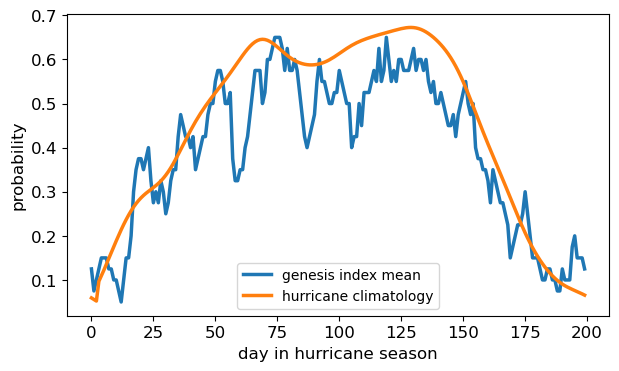

In [19]:
plt.figure(figsize = [7,4])
plt.plot(np.arange(0,200), np.mean(allyears_forDIY, axis = 1), linewidth=2.5, label = 'genesis index mean')
plt.plot(np.arange(0,200), todos_x['hurr_climatology'].iloc[170:370], linewidth=2.5, label = 'hurricane climatology') # lead time thing causing shift in climatology curve 
plt.legend()
plt.xlabel('day in hurricane season')
plt.ylabel('probability')
plt.show()

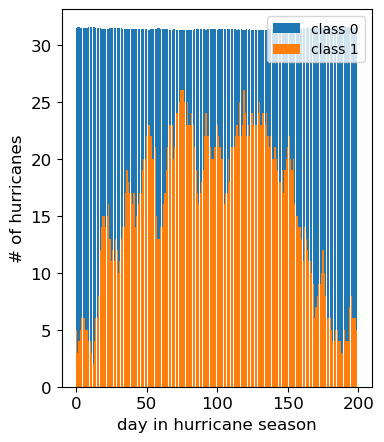

In [116]:
plt.figure(figsize = [4,5])
plt.bar(np.arange(0,200), height = (np.sum(allyears_forDIY)-np.count_nonzero(allyears_forDIY, axis = 1))/100,label = 'class 0') # to "zoom" in
plt.bar(np.arange(0,200), height = np.count_nonzero(allyears_forDIY, axis = 1), label = 'class 1')
plt.legend()
plt.xlabel('day in hurricane season')
plt.ylabel('# of hurricanes')
plt.show()

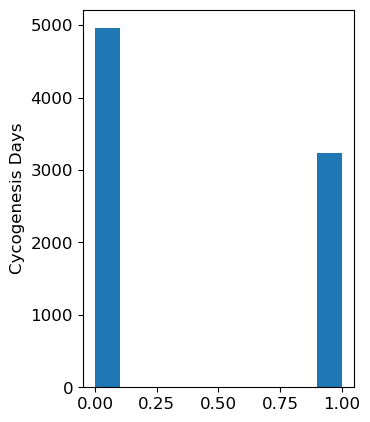

In [21]:
plt.figure()
plt.hist(todos_x['storms_01'])
plt.ylabel('Cycogenesis Days')
plt.show()

#### ORGANIZING ARRAYS THAT CONTAIN FEATURES AND LABELS

In [22]:
todos_x.iloc[:,1:]

,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology
0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465
1,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171
2,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638
3,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751
4,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361
...,...,...,...,...,...,...,...,...,...
8194,1.438178,-0.059600,1.333953,1.101480,4.0,4.010618,303.0,0.215136,0.115381
8195,1.870211,0.256939,1.633875,1.191707,5.0,4.010618,304.0,0.208333,0.109352
8196,2.023075,0.529789,1.797008,1.451394,5.0,4.010618,305.0,0.204082,0.103870
8197,2.168656,0.956396,1.647792,1.762727,5.0,4.010618,306.0,0.208333,0.098930


In [23]:
features = np.array(todos_x.iloc[:,1:])
labels = (np.array(todos_x['storms_01'])).astype(int)

# Saving feature names for later use!!

feature_list = list(todos_x.iloc[:,1:].columns)

# Reminder of what the feature names look like: 

print('features names: \n', feature_list)

features names: 
 ['RMM1', 'RMM2', 'delta_RMM1', 'delta_RMM2', 'mjo_phase', 'enso_index', 'dayinyear', 'raw_climatology', 'hurr_climatology']


#### Split the data into training and testing sets

In [24]:
# Tunable Parameter: Describes the proportion of the dataset we want to use for testing. 1 - split_size is used for training. 
split_size = 0.2

random = 42

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = random, shuffle = False)

In [25]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:  ', train_labels.shape)
print('Testing Features Shape: ', test_features.shape)
print('Testing Labels Shape:   ', test_labels.shape)

print('Total:                  ',train_features.shape[0] + test_labels.shape[0])

Training Features Shape: (6559, 9)
Training Labels Shape:   (6559,)
Testing Features Shape:  (1640, 9)
Testing Labels Shape:    (1640,)
Total:                   8199


In [26]:
dead_season = 0 
one_hurr    = 0
two_hurr    = 0
three_hurr  = 0

for zero in range(0, len(todos_x['storms_01'])): 
    if todos_x['storms_01'][zero] == 0.0: 
        dead_season += 1
    
    else: 
        one_hurr += 1
        
#     else: 
#         two_hurr += 1
        
#     else: 
#         three_hurr += 1
        
print('days with 0 hurricanes:  ', dead_season)
print('days with hurricanes:    ', one_hurr)
# print('days with 1 hurricane:   ', one_hurr)
# print('days with 2 hurricane:   ', two_hurr)
# print('days with 3+ hurricane:  ', three_hurr)
print('length of the data:      ', len(todos_x['storms_01']))
print('')
print('there are', dead_season - (one_hurr), 'days more without hurricanes than with hurricanes! Our data is unbalanced.' )

days with 0 hurricanes:   4964
days with hurricanes:     3235
length of the data:       8199

there are 1729 days more without hurricanes than with hurricanes! Our data is unbalanced.


### **Train model**

#### Make predictions

In [27]:
leaf_samples    = 2       # The minimum number of samples required to be at a leaf node
node_split      = 3       # The minimum number of samples required to split an internal node
number_of_trees = 100      # Number of trees in the forest 
tree_depth      = 5       # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
criterion       = 'entropy'  # 'gini', 'entropy', 'log_loss'
max_feat        = 'auto'    # The number of features to consider when looking for the best split: 'auto', 'sqrt', 'log2', None
boots           = True    # Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree
warm            = False    # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
weight          =  'balanced' # BALANCING THE LABELS: 'balanced', 'balanced_subsample' , {0:w_0_INS, 1:w_1_INS}
oob             = True

cv_predictions  = []

rf = RandomForestClassifier(n_estimators = number_of_trees, random_state = random, min_samples_split = node_split, min_samples_leaf = leaf_samples, criterion = criterion, max_depth = tree_depth, 
                            max_features = max_feat, bootstrap = boots, warm_start = warm, 
                            class_weight = weight, 
                            oob_score = oob
                           )

et = ExtraTreesClassifier(n_estimators = number_of_trees, random_state = random, min_samples_split = node_split, min_samples_leaf = leaf_samples, criterion = criterion, max_depth = tree_depth, 
                            max_features = max_feat, bootstrap = boots, warm_start = warm, 
                            class_weight = weight, 
                            oob_score = oob
                           )
    
rf.fit(train_features, train_labels.ravel());
    
predictions_rf = rf.predict(test_features)

et.fit(train_features, train_labels.ravel());
    
predictions_et = rf.predict(test_features)

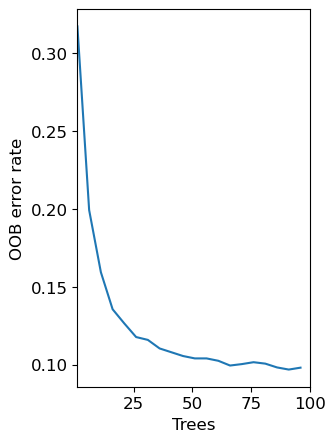

In [28]:
from collections import OrderedDict
from sklearn.datasets import make_classification

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
#     (
#         "RandomForestClassifier, max_features='auto'",
#         RandomForestClassifier(
#             warm_start=True,
#             oob_score=True,
#             max_features="auto",
#             random_state=random,
#         ),
#     ),
#     (
#         "RandomForestClassifier, max_features='log2'",
#         RandomForestClassifier(
#             warm_start=True,
#             max_features="log2",
#             oob_score=True,
#             random_state=random,
#         ),
#     ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=random,
        ),
    ),
]

warnings.filterwarnings('ignore')
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 1
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(train_features, train_labels.ravel())

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        


# Generate the "OOB error rate" vs. "n_estimators" plot.

plt.figure(figsize = [3,5])
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("Trees")
plt.ylabel("OOB error rate")
# plt.legend(loc="upper right")
plt.show()

In [29]:
n_estimators = number_of_trees

arboles = []
fuera_bolsa = []
for i in range(1, n_estimators + 1):
    rf.set_params(n_estimators=i)
    rf.fit(train_features, train_labels.ravel())
    arboles.append(i)
    fuera_bolsa.append(rf.oob_score_)
#     print(i, forest.oob_score_)

warnings.filterwarnings('ignore')

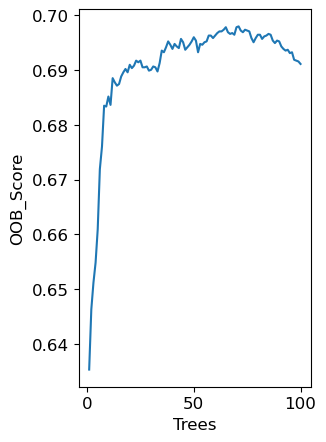

In [30]:
plt.figure(figsize = [3,5])
plt.plot(arboles,fuera_bolsa)
plt.xlabel('Trees')
plt.ylabel('OOB_Score')
warnings.filterwarnings('ignore')

In [31]:
print('rf oob score: ', rf.oob_score_)


oob_fcn = rf.oob_decision_function_

print('rf oob function: ', oob_fcn)


print('et oob score: ', et.oob_score_)


oob_fcn = et.oob_decision_function_

print('et oob function: ', oob_fcn)

rf oob score:  0.6911114499161457
rf oob function:  [[0.49927017 0.50072983]
 [0.50110022 0.49889978]
 [0.46411795 0.53588205]
 ...
 [0.53765677 0.46234323]
 [0.52766699 0.47233301]
 [0.49693865 0.50306135]]
et oob score:  0.6670224119530416
et oob function:  [[0.56228099 0.43771901]
 [0.55606478 0.44393522]
 [0.53537653 0.46462347]
 ...
 [0.52606823 0.47393177]
 [0.49005906 0.50994094]
 [0.51130324 0.48869676]]


In [32]:
from sklearn import metrics
pred_train_rf = np.argmax(rf.oob_decision_function_,axis=1)

rf_roc = metrics.roc_auc_score(train_labels, pred_train_rf)

pred_train_et = np.argmax(et.oob_decision_function_,axis=1)

et_roc = metrics.roc_auc_score(train_labels, pred_train_et)

print(rf_roc, et_roc)

0.7117818686166208 0.6887035169945683


In [33]:
# make predictions on the train set
y_train_pred_rf=rf.predict(train_features)
acc_train_rf = metrics.accuracy_score(train_labels, y_train_pred_rf) # compute the accuracy on the train set
print("training accuracy: ", np.round(acc_train_rf*100), '%')


# make predictions on the train set
y_train_pred_et=et.predict(train_features)
acc_train_et = metrics.accuracy_score(train_labels, y_train_pred_et) # compute the accuracy on the train set
print("training accuracy: ", np.round(acc_train_et*100), '%')

training accuracy:  71.0 %
training accuracy:  67.0 %


Text(0.5, 1.0, 'Training Set')

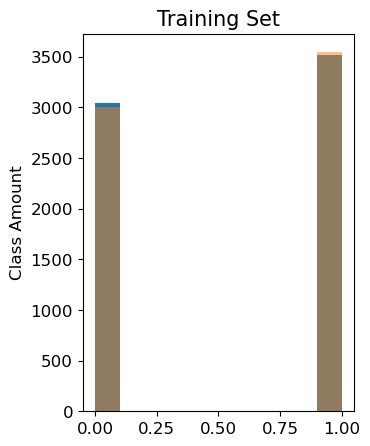

In [34]:
plt.hist(y_train_pred_rf)
plt.hist(y_train_pred_et, alpha = .5)
plt.ylabel('Class Amount')
plt.title('Training Set')

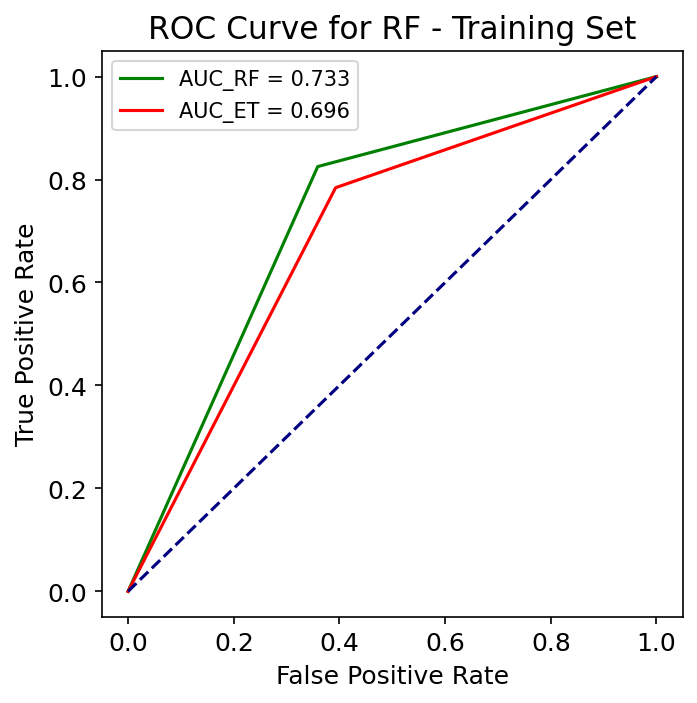

In [35]:
n_classes = rf.n_classes_

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

fprrf, tprrf, _ = metrics.roc_curve(train_labels, y_train_pred_rf)
aucrf = metrics.roc_auc_score(train_labels, y_train_pred_rf)
# fpr, tpr = roc_curve(train_labels, y_train_pred, pos_label=0)
fpret, tpret, _ = metrics.roc_curve(train_labels, y_train_pred_et)
aucet = metrics.roc_auc_score(train_labels, y_train_pred_et)
# PLOT ROC curve
plt.figure(dpi=150, figsize=[5,5])
plt.plot(fprrf, tprrf, color='green', label=f'AUC_RF = {aucrf:.3f}')
plt.plot(fpret, tpret, color='red', label=f'AUC_ET = {aucet:.3f}')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title('ROC Curve for RF - Training Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

In [36]:
# fpr, tpr, thresholds

In [37]:
# make predictions on the test set
y_test_pred_rf=rf.predict(test_features)
acc_test_rf = metrics.accuracy_score(test_labels, y_test_pred_rf) # compute the accuracy on the test set
print("testing accuracy: ", np.around(acc_test_rf*100), '%')

y_test_pred_et=et.predict(test_features)
acc_test_et = metrics.accuracy_score(test_labels, y_test_pred_et) # compute the accuracy on the test set
print("testing accuracy: ", np.around(acc_test_et*100), '%')

testing accuracy:  65.0 %
testing accuracy:  64.0 %


Text(0.5, 1.0, 'Testing Set')

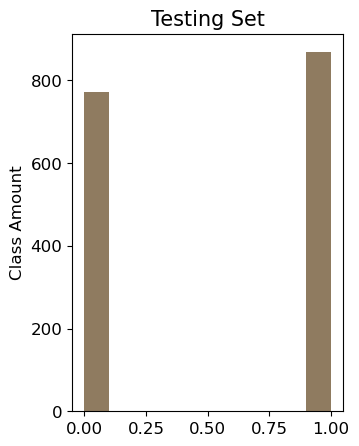

In [38]:
plt.hist(y_test_pred_rf)
plt.hist(y_test_pred_et, alpha=.5)
plt.ylabel('Class Amount')
plt.title('Testing Set')

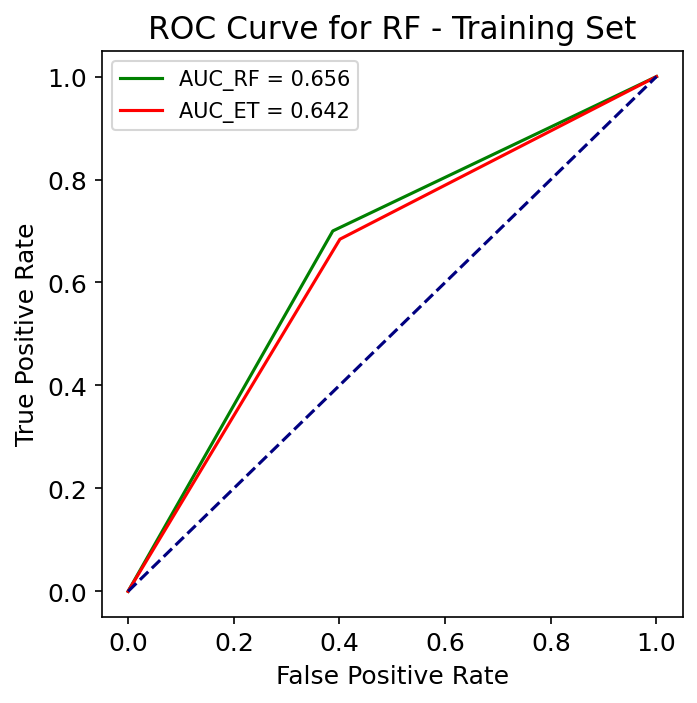

In [39]:
# fpr, tpr, thresholds = roc_curve(test_labels, y_test_pred, pos_label=0)

n_classes = rf.n_classes_

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
# from sklearn.metrics import RocCurveDisplay
# from sklearn.model_selection import train_test_split

fprrf, tprrf, _ = metrics.roc_curve(test_labels,y_test_pred_rf)
aucrf = metrics.roc_auc_score(test_labels,y_test_pred_rf)
# fpr, tpr = roc_curve(train_labels, y_train_pred, pos_label=0)
fpret, tpret, _ = metrics.roc_curve(test_labels,y_test_pred_et)
aucet = metrics.roc_auc_score(test_labels,y_test_pred_et)

# PLOT ROC curve
plt.figure(dpi=150, figsize=[5,5])
plt.plot(fprrf, tprrf, color='green', label=f'AUC_RF = {aucrf:.3f}')
plt.plot(fpret, tpret, color='red', label=f'AUC_ET = {aucet:.3f}')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.title('ROC Curve for RF - Training Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.legend()
plt.show()

# RocCurveDisplay.from_predictions(y_test_pred,test_labels)
# plt.show()


In [40]:
# Creating an array with the corresponding years in the intial datasets

alldates = pd.date_range(start = '1979-01-01', end = '2019-12-31', freq='D')

In [41]:
num2 = len(predictions_rf) # Length of the testing array 
num3 = len(train_features)
print(num2, num3)

1640 6559


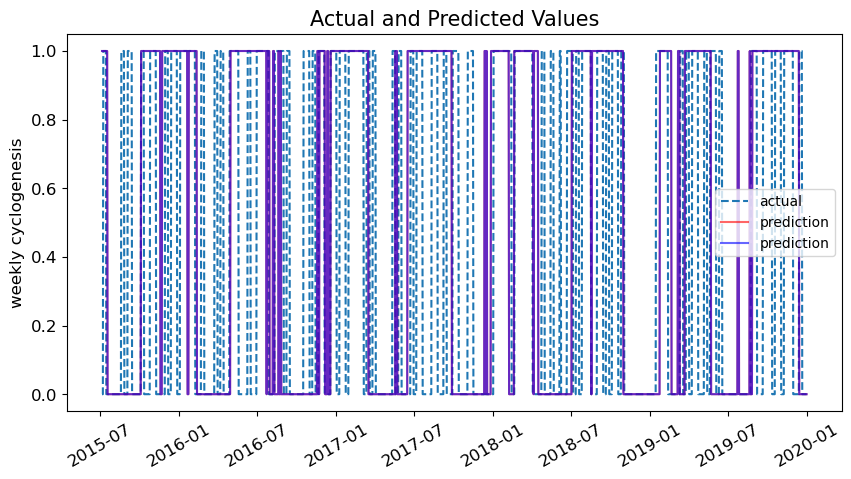

In [42]:
plt.figure(figsize = [10,5])
plt.plot(alldates[-num2:], labels[-num2:], '--', alpha=1, label = 'actual')
plt.plot(alldates[-(num2):], predictions_rf, '-r', alpha=0.6, label = 'prediction')
plt.plot(alldates[-(num2):], predictions_et, '-b', alpha=0.6, label = 'prediction')
plt.xticks(rotation = '30')
plt.legend()
# Graph labels
# plt.xlabel('Date'); 
plt.ylabel('weekly cyclogenesis'); plt.title('Actual and Predicted Values');
plt.show()

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# cv_rf.predict(train)
# cv_predictions[0].shape, labels[-num2:].shape

real_val = (labels[-num2:])


if real_val.shape == predictions_rf.shape: 
    print('tremendoski, chido.')

tremendoski, chido.


In [44]:
real_train_val = (labels[0:len(train_labels)])

train_labels.shape, real_train_val.shape

((6559,), (6559,))

In [45]:
# train_labels.size, y_train_pred.size

[[0.85714286 0.41576551]
 [0.14285714 0.58423449]]
-------------------------------------------------
ACCURACY OF TRAINING SET:   0.7109315444427504
PRECISION OF TRAINING SET:  0.6733735747820254
RECALL OF TRAINING SET:     0.8571428571428571


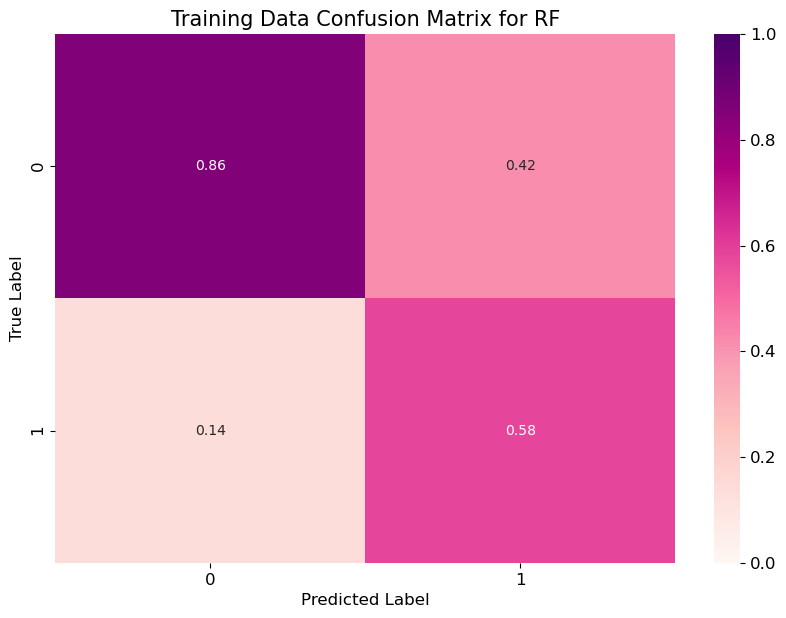

[[0.82153539 0.45042254]
 [0.17846461 0.54957746]]
-------------------------------------------------
ACCURACY OF TRAINING SET:   0.6743406007013264
PRECISION OF TRAINING SET:  0.6458825210085146
RECALL OF TRAINING SET:     0.8215353938185443


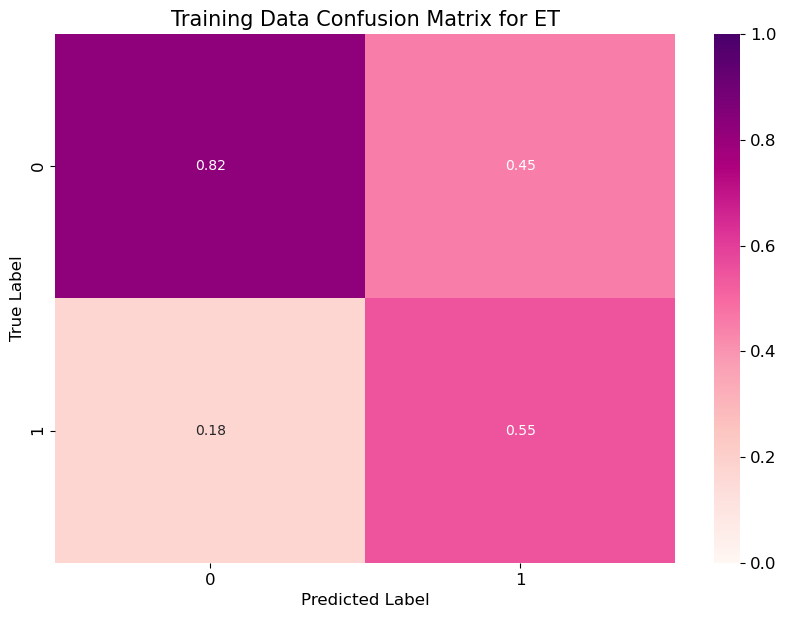

In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix


# ConfusionMatrixDisplay.from_predictions(real_train_val, train_labels)


# y_pred_train = cv_rf.predict(train_labels)
cm_train_rf = confusion_matrix(train_labels, y_train_pred_rf, 
                           normalize = 'pred'
                           )

# accuracy_train = 

precision_train_rf = cm_train_rf[0,0]/(cm_train_rf[0,0]+cm_train_rf[0,1])

recall_train_rf = cm_train_rf[0,0]/(cm_train_rf[0,0]+cm_train_rf[1,0])

print(cm_train_rf)
print('-------------------------------------------------')
print('ACCURACY OF TRAINING SET:  ', acc_train_rf)
print('PRECISION OF TRAINING SET: ', precision_train_rf)
print('RECALL OF TRAINING SET:    ',recall_train_rf)

plt.figure(figsize = (10,7))
sns.heatmap(cm_train_rf, annot = True, cmap = "RdPu", vmin = 0, vmax =1)
plt.title('Training Data Confusion Matrix for RF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig('Training_ConfMatrix_3', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )
plt.show()

cm_train_et = confusion_matrix(train_labels, y_train_pred_et, 
                           normalize = 'pred'
                           )

# accuracy_train = 

precision_train_et = cm_train_et[0,0]/(cm_train_et[0,0]+cm_train_et[0,1])

recall_train_et = cm_train_et[0,0]/(cm_train_et[0,0]+cm_train_et[1,0])

print(cm_train_et)
print('-------------------------------------------------')
print('ACCURACY OF TRAINING SET:  ', acc_train_et)
print('PRECISION OF TRAINING SET: ', precision_train_et)
print('RECALL OF TRAINING SET:    ',recall_train_et)

plt.figure(figsize = (10,7))
sns.heatmap(cm_train_et, annot = True, cmap = "RdPu", vmin = 0, vmax =1)
plt.title('Training Data Confusion Matrix for ET')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig('Training_ConfMatrix_3', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )
plt.show()


[[0.70946822 0.3981588 ]
 [0.29053178 0.6018412 ]]
-------------------------------------------------
ACCURACY OF TESTING SET:   0.6524390243902439
PRECISION OF TESTING SET:  0.6405298952040739
RECALL OF TESTING SET:     0.7094682230869002


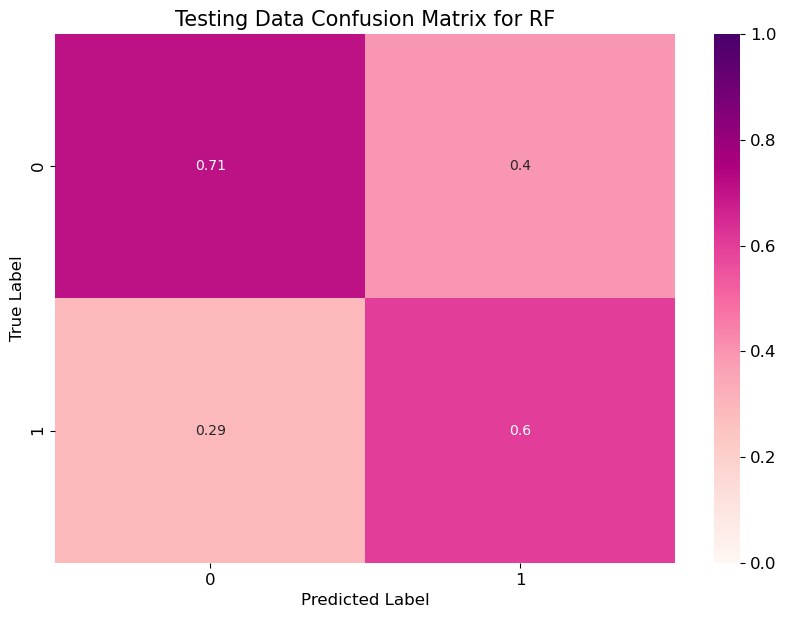

[[0.70946822 0.3981588 ]
 [0.29053178 0.6018412 ]]
-------------------------------------------------
ACCURACY OF TESTING SET:   0.6378048780487805
PRECISION OF TESTING SET:  0.6405298952040739
RECALL OF TESTING SET:     0.7094682230869002


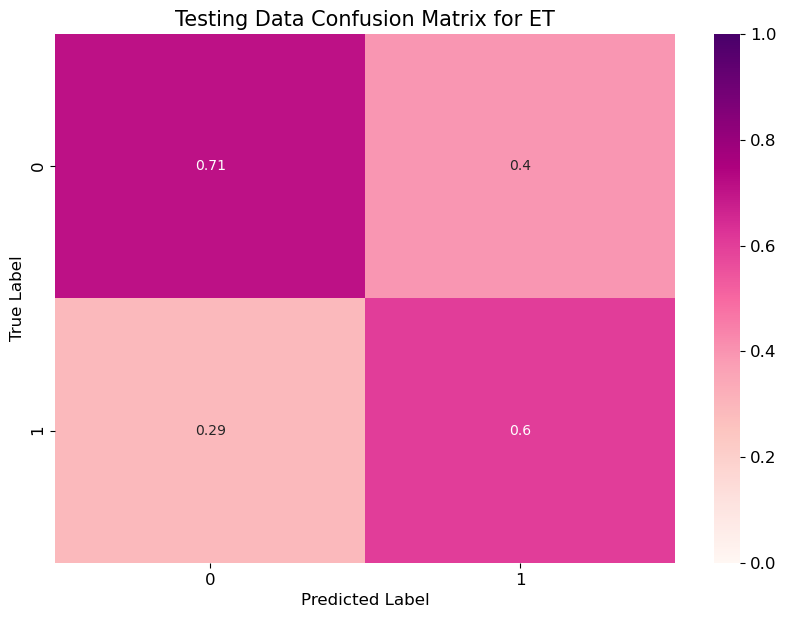

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

# y_pred_train = cv_rf.predict(train_labels)

# print('training confusion matrix')

cm_test_rf = confusion_matrix(labels[-num2:], predictions_rf, 
                           normalize = 'pred'
#                            sample_weight =( w_0_INS, w_1_INS)
                          )
print(cm_test_rf)

precision_test_rf = cm_test_rf[0,0]/(cm_test_rf[0,0]+cm_test_rf[0,1])

recall_test_rf = cm_test_rf[0,0]/(cm_test_rf[0,0]+cm_test_rf[1,0])

print('-------------------------------------------------')
print('ACCURACY OF TESTING SET:  ', acc_test_rf)
print('PRECISION OF TESTING SET: ', precision_test_rf)
print('RECALL OF TESTING SET:    ',recall_test_rf)

plt.figure(figsize = (10,7))
sns.heatmap(cm_test_rf, annot = True, cmap="RdPu", vmin = 0, vmax =1)
plt.title('Testing Data Confusion Matrix for RF')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig('Testing_ConfMatrix_3', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )
plt.show()

cm_test_et = confusion_matrix(labels[-num2:], predictions_et, 
                           normalize = 'pred'
#                            sample_weight =( w_0_INS, w_1_INS)
                          )
print(cm_test_et)

precision_test_et = cm_test_et[0,0]/(cm_test_et[0,0]+cm_test_et[0,1])

recall_test_et = cm_test_et[0,0]/(cm_test_et[0,0]+cm_test_et[1,0])

print('-------------------------------------------------')
print('ACCURACY OF TESTING SET:  ', acc_test_et)
print('PRECISION OF TESTING SET: ', precision_test_et)
print('RECALL OF TESTING SET:    ',recall_test_et)

plt.figure(figsize = (10,7))
sns.heatmap(cm_test_et, annot = True, cmap="RdPu", vmin = 0, vmax =1)
plt.title('Testing Data Confusion Matrix for ET')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.savefig('Testing_ConfMatrix_3', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )
plt.show()

In [48]:
# plt.plot([cm_train[0,0],cm_train[1,1],acc_train])
# plt.plot([cm_test[0,0],cm_test[1,1],acc_test])

#### Truth vs Prediction - testing sample

In [49]:
#%% Probability of getting any of the 4 classes

pr_train_rf = rf.predict_proba(train_features)

pr_test_rf = rf.predict_proba(test_features)


pr_train_et = et.predict_proba(train_features)

pr_test_et = et.predict_proba(test_features)

test_labels_rf = (test_labels).astype(int)

train_labels_rf = (train_labels).astype(int)


class0_rf = np.zeros(len(test_labels))
class1_rf = np.zeros(len(test_labels))

class0_train_rf = np.zeros(len(train_labels))
class1_train_rf = np.zeros(len(train_labels))





# pr_train_et = et.predict_proba(train_features)

# pr_test_et = et.predict_proba(test_features)

# test_labels_et = (test_labels).astype(int)

# train_labels_et = (train_labels).astype(int)


# class0_et = np.zeros(len(test_labels))
# class1_et = np.zeros(len(test_labels))

# class0_train_et = np.zeros(len(train_labels))
# class1_train_et = np.zeros(len(train_labels))


for test in range(len(test_labels_rf)):
    if test_labels_rf[test] == 0: 
        class0_rf[test] = 100
    elif test_labels_rf[test] == 1:
        class1_rf[test] = 100

        
for train in range(len(train_labels_rf)):
    if train_labels_rf[train] == 0: 
        class0_train_rf[train] = 100
    elif train_labels_rf[train] == 1:
        class1_train_rf[train] = 100
#     elif test_labels[test] == 2:
#         class2[test] = 100
#     elif test_labels[test] == 3:
#         class3[test] = 100

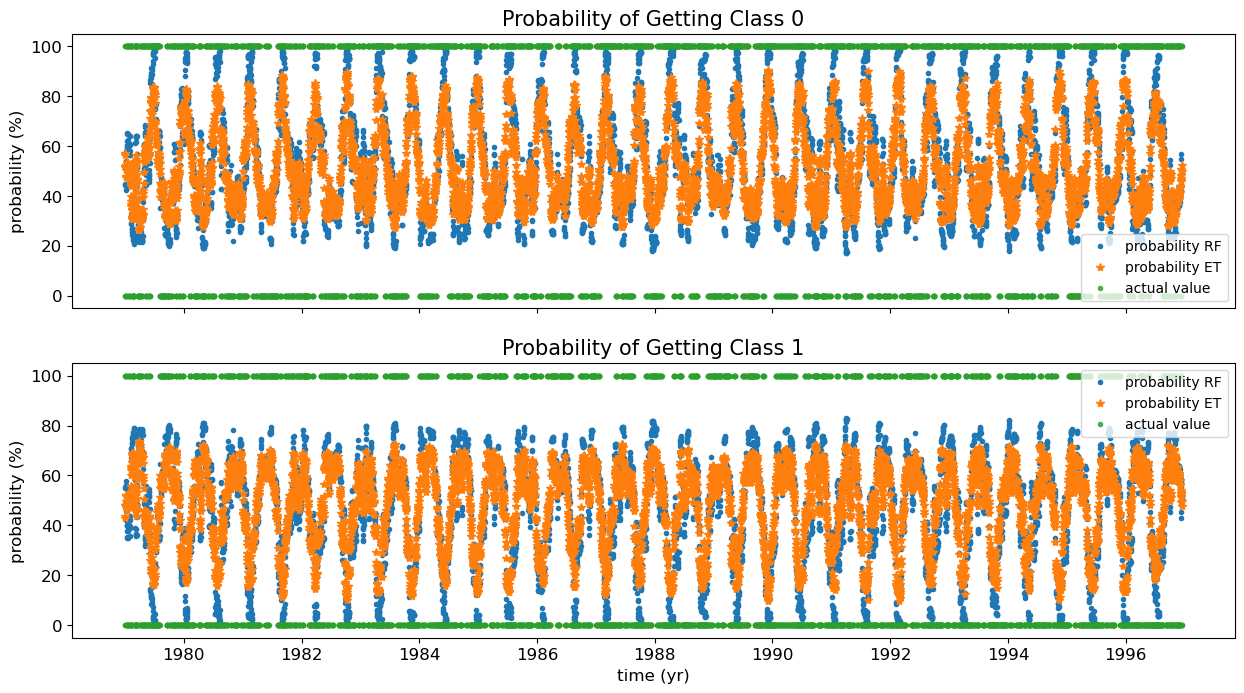

In [50]:
# TRAINING SET
fig, axs = plt.subplots(2,1, figsize = (15,8))
axs[0].plot(alldates[:num3], pr_train_rf[:,0]*100, '.', label = 'probability RF')
axs[0].plot(alldates[:num3], pr_train_et[:,0]*100, '*', label = 'probability ET')
axs[0].plot(alldates[:num3], class0_train_rf, '.', alpha = .8, label = 'actual value')
axs[0].set_title('Probability of Getting Class 0')
axs[1].plot(alldates[:num3], pr_train_rf[:,1]*100, '.', label = 'probability RF')
axs[1].plot(alldates[:num3], pr_train_et[:,1]*100, '*', label = 'probability ET')
axs[1].plot(alldates[:num3], class1_train_rf, '.', alpha = .8, label = 'actual value')
axs[1].set_title('Probability of Getting Class 1')
# ax.set_title('Training Set')
# axs[2].plot(alldates[-num2:], pr_test[:,2]*100, '.', label = 'probability')
# axs[2].plot(alldates[-num2:], class2, '.', alpha = .8, label = 'actual value')
# axs[2].set_title('Probability of Getting Class 2')
# axs[1, 1].plot(alldates[-num2:], pr_test[:,3]*100, '.', label = 'probability')
# axs[1, 1].plot(alldates[-num2:], class3, '.', alpha = .8, label = 'actual value')
# axs[1, 1].set_title('Probability of Getting Class 3')

for ax in axs.flat:
    ax.set(xlabel='time (yr)', ylabel='probability (%)')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

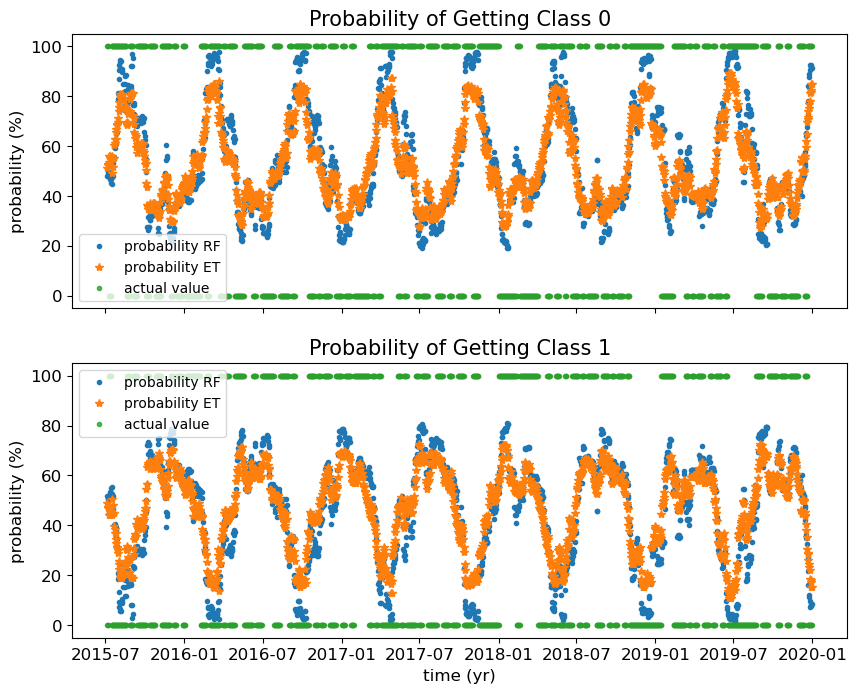

In [51]:
# TESTING SET
fig, axs = plt.subplots(2,1, figsize = (10,8))
axs[0].plot(alldates[-num2:], pr_test_rf[:,0]*100, '.', label = 'probability RF')
axs[0].plot(alldates[-num2:], pr_test_et[:,0]*100, '*', label = 'probability ET')
axs[0].plot(alldates[-num2:], class0_rf, '.', alpha = .8, label = 'actual value')
axs[0].set_title('Probability of Getting Class 0')
axs[1].plot(alldates[-num2:], pr_test_rf[:,1]*100, '.', label = 'probability RF')
axs[1].plot(alldates[-num2:], pr_test_et[:,1]*100, '*', label = 'probability ET')
axs[1].plot(alldates[-num2:], class1_rf, '.', alpha = .8, label = 'actual value')
axs[1].set_title('Probability of Getting Class 1')
# axs[2].plot(alldates[-num2:], pr_test[:,2]*100, '.', label = 'probability')
# axs[2].plot(alldates[-num2:], class2, '.', alpha = .8, label = 'actual value')
# axs[2].set_title('Probability of Getting Class 2')
# axs[1, 1].plot(alldates[-num2:], pr_test[:,3]*100, '.', label = 'probability')
# axs[1, 1].plot(alldates[-num2:], class3, '.', alpha = .8, label = 'actual value')
# axs[1, 1].set_title('Probability of Getting Class 3')

for ax in axs.flat:
    ax.set(xlabel='time (yr)', ylabel='probability (%)')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
# plt.savefig('ClassProbs_2', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )
    

#### Probability of getting any of the 4 classes 

#### Printing out a tree

In [52]:
# # from sklearn.tree import export_graphviz

# # from graphvixz import Source

# from sklearn import tree

# # mpl.rcParams['figure.dpi'] = 2000

# # local_path = '/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/phase_3'

# arbol = rf.estimators_[0]
# # filename = 'RF_Tree_HP'

# # # Export the image to a dot file
# # export_graphviz(tree, out_file = '{}/{}.dot'.format(local_path, filename), feature_names = feature_list, rounded = True, precision = 1)
# # Source.from_file('{}/{}.dot'.format(local_path, filename))

# tree.plot_tree(arbol, feature_names = feature_list, max_depth = 3, impurity = True)
# # plt.savefig('/Volumes/GoogleDrive-103067098319523494445/My Drive/WORK/phase_3/tree_pcmdi.png')
# plt.show()

In [53]:
def calc_importances(rf, feature_list):

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

    return importances

In [54]:
def plot_feat_importances(importances, feature_list): 
    plt.figure()
    # Set the style
#     plt.style.use('bmh')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')

Variable: dayinyear            Importance: 0.34
Variable: hurr_climatology     Importance: 0.27
Variable: RMM1                 Importance: 0.1
Variable: raw_climatology      Importance: 0.08
Variable: RMM2                 Importance: 0.06
Variable: delta_RMM1           Importance: 0.05
Variable: delta_RMM2           Importance: 0.05
Variable: enso_index           Importance: 0.04
Variable: mjo_phase            Importance: 0.03


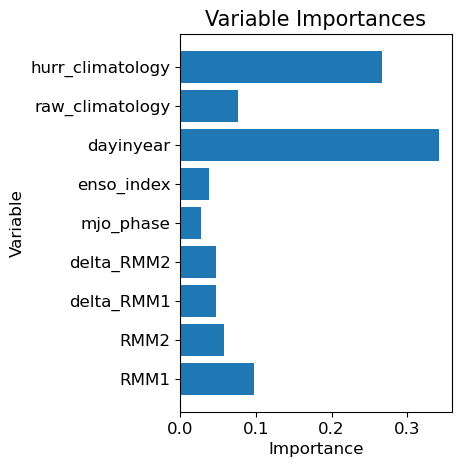

Variable: hurr_climatology     Importance: 0.44
Variable: dayinyear            Importance: 0.21
Variable: raw_climatology      Importance: 0.09
Variable: RMM1                 Importance: 0.06
Variable: mjo_phase            Importance: 0.06
Variable: RMM2                 Importance: 0.04
Variable: delta_RMM2           Importance: 0.04
Variable: delta_RMM1           Importance: 0.03
Variable: enso_index           Importance: 0.02


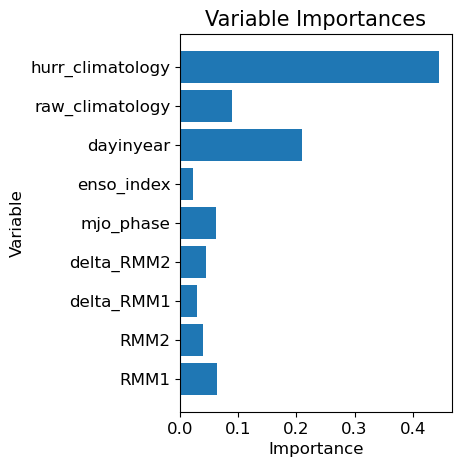

In [55]:
# plot_feat_importances(calc_importances(rf, feature_list[:9]), feature_list[:9])
plot_feat_importances(calc_importances(rf, feature_list), feature_list)
plt.show()
# plt.savefig('Variable_Importances_3', dpi=300, format=None, metadata=None,
#         bbox_inches='tight', pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',
#            )

plot_feat_importances(calc_importances(et, feature_list), feature_list)
plt.show()

In [56]:
# Single-pass permutation
permute = permutation_importance(rf, test_features, test_labels, n_repeats=10, 
                                 random_state=random)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

In [57]:
def plot_perm_importances(permute, sorted_idx, feature_list):
  # Sort the feature list based on 

    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title("Permutation Importances")
    fig.tight_layout()

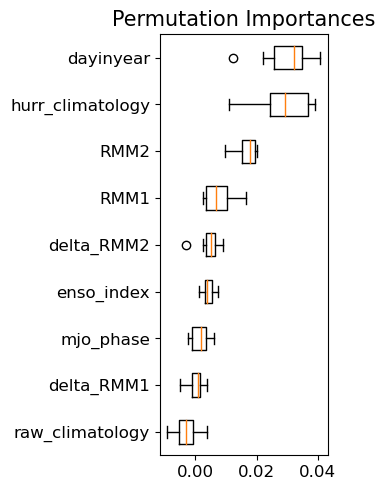

In [58]:
plot_perm_importances(permute, sorted_idx, feature_list)

training set

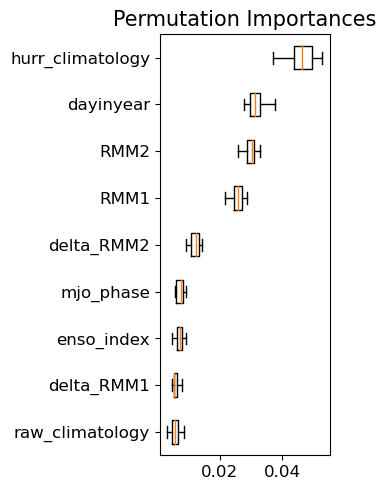

In [59]:
permute = permutation_importance(rf, train_features, train_labels, n_repeats=10, random_state=random)
sorted_idx = permute.importances_mean.argsort()

plot_perm_importances(permute, sorted_idx, feature_list)

#### predictions during la nina and el nino (on subsets) 

In [60]:
rf_classifications = todos_x['storms_01'].iloc[:(len(train_features))]

rf_classifications = np.append(rf_classifications, predictions_rf)

et_classifications = todos_x['storms_01'].iloc[:(len(train_features))]

et_classifications = np.append(et_classifications, predictions_et)

# print(pr_train)

In [61]:
todos_x['rf_classes'] = rf_classifications

todos_x['et_classes'] = et_classifications

display(todos_x)

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology,rf_classes,et_classes
0,0.0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465,0.0,0.0
1,0.0,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171,0.0,0.0
2,1.0,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638,1.0,1.0
3,1.0,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751,1.0,1.0
4,1.0,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8194,0.0,1.438178,-0.059600,1.333953,1.101480,4.0,4.010618,303.0,0.215136,0.115381,0.0,0.0
8195,0.0,1.870211,0.256939,1.633875,1.191707,5.0,4.010618,304.0,0.208333,0.109352,0.0,0.0
8196,0.0,2.023075,0.529789,1.797008,1.451394,5.0,4.010618,305.0,0.204082,0.103870,0.0,0.0
8197,0.0,2.168656,0.956396,1.647792,1.762727,5.0,4.010618,306.0,0.208333,0.098930,0.0,0.0


In [62]:
probabilities_class0_rf = pr_test_rf[:,0]

probabilities_class0_rf = np.append(probabilities_class0_rf, pr_train_rf[:,0])

probabilities_class1_rf = pr_test_rf[:,1]

probabilities_class1_rf = np.append(probabilities_class1_rf, pr_train_rf[:,1])


probabilities_class0_et = pr_test_et[:,0]

probabilities_class0_et = np.append(probabilities_class0_et, pr_train_et[:,0])

probabilities_class1_et = pr_test_et[:,1]

probabilities_class1_et = np.append(probabilities_class1_et, pr_train_et[:,1])

In [63]:
todos_x['pr_class0_rf'] = probabilities_class0_rf
todos_x['pr_class1_rf'] = probabilities_class1_rf

todos_x['pr_class0_et'] = probabilities_class0_et
todos_x['pr_class1_et'] = probabilities_class1_et

In [64]:
# todos_x['storms_01'] = np.round(todos_x['storms_01'])

In [65]:
#Identifying El Nino and La Nina events

boy = []

for gender in range(0, len(todos_x)): 
    if todos_x['enso_index'].iloc[gender] >= 0.5: 
        boy.append(1)
    elif todos_x['enso_index'].iloc[gender] <= -0.5: 
        boy.append(0)
    else: 
        boy.append(2)
        
# print(boy)
    

In [66]:
todos_x['el_nino?'] = boy # 1 = yes, 0 = no, 2 = neutral 

In [67]:
el_nino = todos_x.where(todos_x['el_nino?'] == 1.0)

el_nino = (el_nino.dropna(how = 'any')).reset_index(drop = True)

# display(el_nino)

In [68]:
la_nina = todos_x.where(todos_x['el_nino?'] == 0.0)

la_nina = (la_nina.dropna(how = 'any')).reset_index(drop = True)

# display(la_nina)

In [69]:
neutral = todos_x.where(todos_x['el_nino?'] == 2.0)

neutral = (neutral.dropna(how = 'any')).reset_index(drop = True)

# display(neutral)

In [70]:
print(np.sum(neutral['storms_01']), np.sum(el_nino['storms_01']), np.sum(la_nina['storms_01']))

1345.0 1067.0 823.0


In [71]:
# plt.hist(todos_x['el_nino?'], bins = 'auto')

In [72]:
# plt.style.use('dark_background')

# plt.figure(figsize = [12, 4])
# plt.scatter(todos_x['year2'], todos_x['pr_class1']*100, c = todos_x['enso_index'], cmap = "RdPu")
# plt.title('RF cyclogenesis probability and ENSO Index')
# plt.ylabel('% probability')
# plt.colorbar(label = 'ENSO index')
# plt.show()

In [73]:
# plt.style.use('dark_background')

# plt.figure(figsize = [12, 4])
# plt.scatter(el_nino['year2'], el_nino['pr_class1']*100, c = el_nino['enso_index'], cmap = "RdPu")
# plt.title('RF cyclogenesis probability during El Nino')
# plt.ylabel('% probability')
# plt.colorbar(label = 'ENSO index')
# plt.show()

In [74]:
# plt.figure(figsize = [12, 4])
# plt.scatter(la_nina['year2'], la_nina['pr_class1']*100, c = la_nina['enso_index'], cmap = "RdPu_r")
# plt.title('RF cyclogenesis probability during La Nina')
# plt.colorbar(label = 'ENSO index')
# plt.ylabel('% probability of cyclogenesis')
# plt.show()

In [75]:
# plt.figure(figsize = [12, 4])
# plt.scatter(neutral['year2'], neutral['pr_class1']*100, c = neutral['enso_index'], cmap = "RdPu")
# plt.title('RF cyclogenesis probability during Neutral years')
# plt.colorbar(label = 'ENSO index')
# plt.ylabel('% probability of cyclogenesis')
# plt.show()

In [76]:
print('for El Nino:')
print('Cyclogenesis: ', np.sum(el_nino['storms_01']))
print('RF:           ', np.sum(el_nino['rf_classes']))
print('------------------------------------------')
print('for La Nina:')
print('Cyclogenesis: ', np.sum(la_nina['storms_01']))
print('RF:           ', np.sum(la_nina['rf_classes']))
print('------------------------------------------')
print('for Neutral years:')
print('Cyclogenesis: ', np.sum(neutral['storms_01']))
print('RF:           ', np.sum(neutral['rf_classes']))

for El Nino:
Cyclogenesis:  1067.0
RF:            1112.0
------------------------------------------
for La Nina:
Cyclogenesis:  823.0
RF:            859.0
------------------------------------------
for Neutral years:
Cyclogenesis:  1345.0
RF:            1386.0


In [77]:
todos_x_testing = todos_x.iloc[:-len(test_features)]

# display(todos_x_testing)

el_nino_test = todos_x_testing.where(todos_x_testing['el_nino?'] == 1.0)

el_nino_test = (el_nino_test.dropna(how = 'any')).reset_index(drop = True)

# display(el_nino_test)

la_nina_test = todos_x_testing.where(todos_x_testing['el_nino?'] == 0.0)

la_nina_test = (la_nina_test.dropna(how = 'any')).reset_index(drop = True)

# display(la_nina_test)

neutral_test = todos_x_testing.where(todos_x_testing['el_nino?'] == 2.0)

neutral_test = (neutral_test.dropna(how = 'any')).reset_index(drop = True)

# display(neutral_test)


In [78]:
# fig, ax = plt.subplots()
# ax.plot([np.sum(el_nino['storms_01'])/len(el_nino),np.sum(la_nina['storms_01'])/len(la_nina), np.sum(neutral['storms_01'])/len(neutral)], label='real')
# ax.plot([np.sum(el_nino['rf_classes'])/len(el_nino),np.sum(la_nina['rf_classes'])/len(la_nina), np.sum(neutral['rf_classes'])/len(neutral)], label = 'RF')
# ax.plot([np.sum(el_nino_test['rf_classes'])/len(el_nino_test),np.sum(la_nina_test['rf_classes'])/len(la_nina_test), np.sum(neutral_test['rf_classes'])/len(neutral_test)], label = 'Testing Set')
# ax.set_xticks([0,1,2])
# ax.set_xticklabels(['La Nina','El Nino', 'Neutral'])
# ax.legend()
# plt.show()

In [79]:
#Plotting these values: 

# nino_cyclogenesis = [np.sum(el_nino['storms_01']),np.sum(la_nina['storms_01']),np.sum(neutral['storms_01'])]

# nino_rf_cyclogenesis = [np.sum(el_nino['rf_classes']), np.sum(la_nina['rf_classes']), np.sum(neutral['rf_classes'])]

# nino_phases = np.arange(1,4)

# plt.figure(figsize = [10,6])
# plt.plot(nino_phases,nino_cyclogenesis, label = 'real')
# plt.plot(nino_phases, nino_rf_cyclogenesis, label = 'RF')
# plt.xlabel('ENSO')
# plt.ylabel('Cyclogenesis #')
# plt.title('Cyclogenesis per ENSO Index \n from 1979 - 2019')
# plt.legend()
# plt.show()


#### predictions for climatology

In [80]:
# plt.figure(figsize = [12, 4])
# plt.scatter(todos_x['year2'], todos_x['pr_class1']*100, c = todos_x['hurr_climatology'], cmap = "RdPu")
# plt.title('RF cyclogenesis probability for hurricane climatology')
# plt.colorbar(label = 'hurr_climatology')
# plt.ylabel('% probability of cyclogenesis')
# plt.show()

#### predictions during MJO phases

In [81]:
display(todos_x)

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology,rf_classes,et_classes,pr_class0_rf,pr_class1_rf,pr_class0_et,pr_class1_et,el_nino?
0,0.0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465,0.0,0.0,0.480641,0.519359,0.510809,0.489191,0
1,0.0,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171,0.0,0.0,0.492931,0.507069,0.525340,0.474660,0
2,1.0,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638,1.0,1.0,0.499803,0.500197,0.529034,0.470966,0
3,1.0,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751,1.0,1.0,0.486071,0.513929,0.535372,0.464628,0
4,1.0,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361,1.0,1.0,0.495735,0.504265,0.558122,0.441878,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194,0.0,1.438178,-0.059600,1.333953,1.101480,4.0,4.010618,303.0,0.215136,0.115381,0.0,0.0,0.482506,0.517494,0.482403,0.517597,1
8195,0.0,1.870211,0.256939,1.633875,1.191707,5.0,4.010618,304.0,0.208333,0.109352,0.0,0.0,0.548143,0.451857,0.485553,0.514447,1
8196,0.0,2.023075,0.529789,1.797008,1.451394,5.0,4.010618,305.0,0.204082,0.103870,0.0,0.0,0.569856,0.430144,0.506016,0.493984,1
8197,0.0,2.168656,0.956396,1.647792,1.762727,5.0,4.010618,306.0,0.208333,0.098930,0.0,0.0,0.493245,0.506755,0.500755,0.499245,1


In [82]:
# plt.figure(figsize = [12, 4])
# plt.scatter(todos_x['year2'], todos_x['pr_class1']*100, c = todos_x['mjo_phase'], cmap = "RdPu")
# plt.title('RF cyclogenesis probability for MJO Phase')
# plt.colorbar(label = 'mjo_phase')
# plt.ylabel('% probability of cyclogenesis')
# plt.show()

#### Counting cyclogenesis per mjo phase 

In [83]:
phase1 = ((todos_x.where(todos_x['mjo_phase'] == 1.0)).dropna(how = 'any')).reset_index(drop = True)
phase2 = ((todos_x.where(todos_x['mjo_phase'] == 2.0)).dropna(how = 'any')).reset_index(drop = True)
phase3 = ((todos_x.where(todos_x['mjo_phase'] == 3.0)).dropna(how = 'any')).reset_index(drop = True)
phase4 = ((todos_x.where(todos_x['mjo_phase'] == 4.0)).dropna(how = 'any')).reset_index(drop = True)
phase5 = ((todos_x.where(todos_x['mjo_phase'] == 5.0)).dropna(how = 'any')).reset_index(drop = True)
phase6 = ((todos_x.where(todos_x['mjo_phase'] == 6.0)).dropna(how = 'any')).reset_index(drop = True)
phase7 = ((todos_x.where(todos_x['mjo_phase'] == 7.0)).dropna(how = 'any')).reset_index(drop = True)
phase8 = ((todos_x.where(todos_x['mjo_phase'] == 8.0)).dropna(how = 'any')).reset_index(drop = True)

phase1_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 1.0)).dropna(how = 'any')).reset_index(drop = True)
phase2_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 2.0)).dropna(how = 'any')).reset_index(drop = True)
phase3_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 3.0)).dropna(how = 'any')).reset_index(drop = True)
phase4_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 4.0)).dropna(how = 'any')).reset_index(drop = True)
phase5_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 5.0)).dropna(how = 'any')).reset_index(drop = True)
phase6_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 6.0)).dropna(how = 'any')).reset_index(drop = True)
phase7_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 7.0)).dropna(how = 'any')).reset_index(drop = True)
phase8_testing = ((todos_x_testing.where(todos_x_testing['mjo_phase'] == 8.0)).dropna(how = 'any')).reset_index(drop = True)

In [84]:
print('for mjo phase 1:')
print('Cyclogenesis: ', np.sum(phase1['storms_01']))
print('RF:           ', np.sum(phase1['rf_classes']))
# print('RF:           ', np.sum(phase1_testing['rf_classes']))
print('------------------------------------------')
print('for mjo phase 2:')
print('Cyclogenesis: ', np.sum(phase2['storms_01']))
print('RF:           ', np.sum(phase2['rf_classes']))
print('------------------------------------------')
print('for mjo phase 3:')
print('Cyclogenesis: ', np.sum(phase3['storms_01']))
print('RF:           ', np.sum(phase3['rf_classes']))
print('------------------------------------------')
print('for mjo phase 4:')
print('Cyclogenesis: ', np.sum(phase4['storms_01']))
print('RF:           ', np.sum(phase4['rf_classes']))
print('------------------------------------------')
print('for mjo phase 5:')
print('Cyclogenesis: ', np.sum(phase5['storms_01']))
print('RF:           ', np.sum(phase5['rf_classes']))
print('------------------------------------------')
print('for mjo phase 6:')
print('Cyclogenesis: ', np.sum(phase6['storms_01']))
print('RF:           ', np.sum(phase6['rf_classes']))
print('------------------------------------------')
print('for mjo phase 7:')
print('Cyclogenesis: ', np.sum(phase7['storms_01']))
print('RF:           ', np.sum(phase7['rf_classes']))
print('------------------------------------------')
print('for mjo phase 8:')
print('Cyclogenesis: ', np.sum(phase8['storms_01']))
print('RF:           ', np.sum(phase8['rf_classes']))

for mjo phase 1:
Cyclogenesis:  736.0
RF:            789.0
------------------------------------------
for mjo phase 2:
Cyclogenesis:  537.0
RF:            531.0
------------------------------------------
for mjo phase 3:
Cyclogenesis:  333.0
RF:            333.0
------------------------------------------
for mjo phase 4:
Cyclogenesis:  325.0
RF:            336.0
------------------------------------------
for mjo phase 5:
Cyclogenesis:  332.0
RF:            355.0
------------------------------------------
for mjo phase 6:
Cyclogenesis:  268.0
RF:            273.0
------------------------------------------
for mjo phase 7:
Cyclogenesis:  279.0
RF:            307.0
------------------------------------------
for mjo phase 8:
Cyclogenesis:  425.0
RF:            433.0


In [85]:
# todos_x_testing

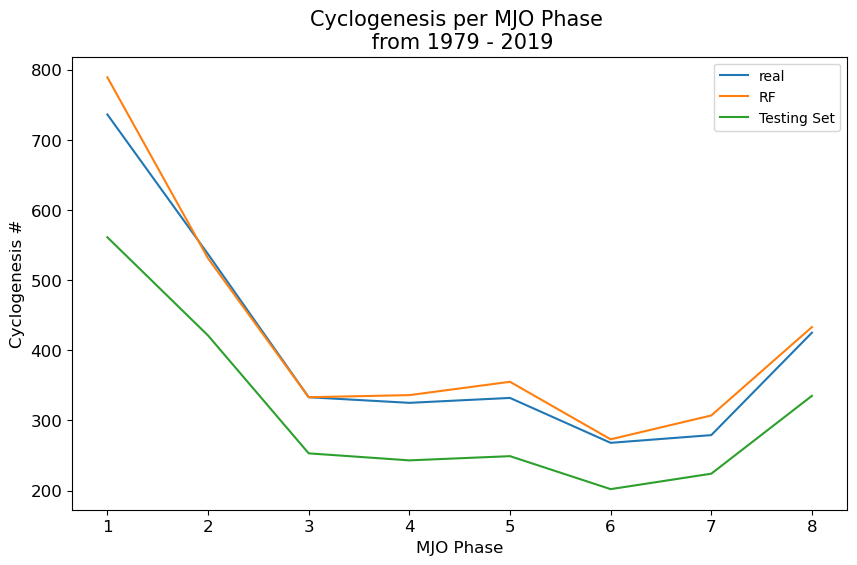

In [86]:
#plotting these phase1_testing

mjo_cyclogenesis = [np.sum(phase1['storms_01']),np.sum(phase2['storms_01']),np.sum(phase3['storms_01']),np.sum(phase4['storms_01']),
                    np.sum(phase5['storms_01']),np.sum(phase6['storms_01']),np.sum(phase7['storms_01']),np.sum(phase8['storms_01'])]

rf_cyclogenesis = [np.sum(phase1['rf_classes']), np.sum(phase2['rf_classes']), np.sum(phase3['rf_classes']), np.sum(phase4['rf_classes']), 
                   np.sum(phase5['rf_classes']), np.sum(phase6['rf_classes']), np.sum(phase7['rf_classes']), np.sum(phase8['rf_classes'])]

rf_cyclogenesis_testing = [np.sum(phase1_testing['rf_classes']), np.sum(phase2_testing['rf_classes']), np.sum(phase3_testing['rf_classes']), np.sum(phase4_testing['rf_classes']), 
                   np.sum(phase5_testing['rf_classes']), np.sum(phase6_testing['rf_classes']), np.sum(phase7_testing['rf_classes']), np.sum(phase8_testing['rf_classes'])]

mjo_phases = np.arange(1,9)

plt.figure(figsize = [10,6])
plt.plot(mjo_phases,mjo_cyclogenesis, label = 'real')
plt.plot(mjo_phases, rf_cyclogenesis, label = 'RF')
plt.plot(mjo_phases, rf_cyclogenesis_testing, label = 'Testing Set')
plt.xlabel('MJO Phase')
plt.ylabel('Cyclogenesis #')
plt.title('Cyclogenesis per MJO Phase \n from 1979 - 2019')
plt.legend()
plt.show()


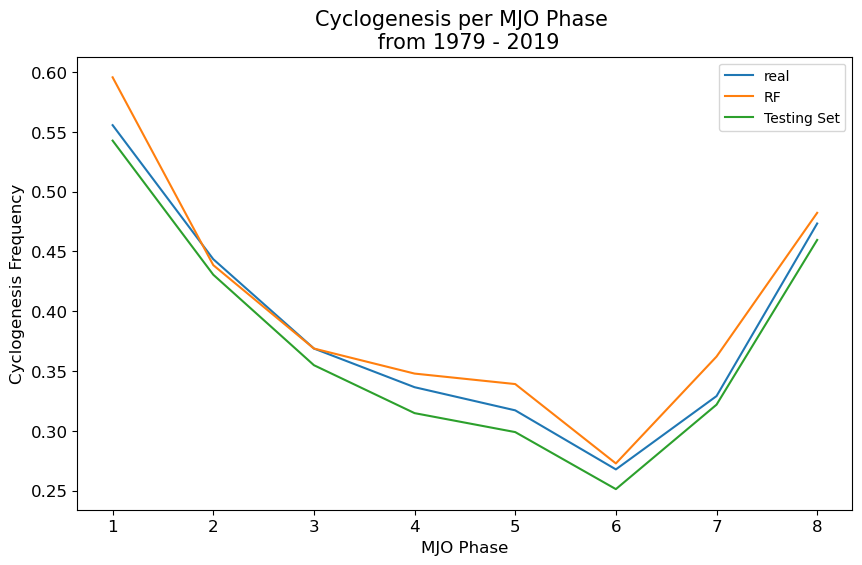

In [87]:
#MJO phase frequenxy plot 

mjo_cyclogenesis_f = [np.sum(phase1['storms_01'])/len(phase1),np.sum(phase2['storms_01'])/len(phase2),np.sum(phase3['storms_01'])/len(phase3),np.sum(phase4['storms_01'])/len(phase4),
                    np.sum(phase5['storms_01'])/len(phase5),np.sum(phase6['storms_01'])/len(phase6),np.sum(phase7['storms_01'])/len(phase7),np.sum(phase8['storms_01'])/len(phase8)]

rf_cyclogenesis_f = [np.sum(phase1['rf_classes'])/len(phase1),np.sum(phase2['rf_classes'])/len(phase2),np.sum(phase3['rf_classes'])/len(phase3),np.sum(phase4['rf_classes'])/len(phase4),
                    np.sum(phase5['rf_classes'])/len(phase5),np.sum(phase6['rf_classes'])/len(phase6),np.sum(phase7['rf_classes'])/len(phase7),np.sum(phase8['rf_classes'])/len(phase8)]

rf_cyclogenesis_testing_f = [np.sum(phase1_testing['rf_classes'])/len(phase1_testing), np.sum(phase2_testing['rf_classes'])/len(phase2_testing), np.sum(phase3_testing['rf_classes'])/len(phase3_testing), np.sum(phase4_testing['rf_classes'])/len(phase4_testing), 
                   np.sum(phase5_testing['rf_classes'])/len(phase5_testing), np.sum(phase6_testing['rf_classes'])/len(phase6_testing), np.sum(phase7_testing['rf_classes'])/len(phase7_testing), np.sum(phase8_testing['rf_classes'])/len(phase8_testing)]

plt.figure(figsize = [10,6])
plt.plot(mjo_phases,mjo_cyclogenesis_f, label = 'real')
plt.plot(mjo_phases, rf_cyclogenesis_f, label = 'RF')
plt.plot(mjo_phases, rf_cyclogenesis_testing_f, label = 'Testing Set')
plt.xlabel('MJO Phase')
plt.ylabel('Cyclogenesis Frequency')
plt.title('Cyclogenesis per MJO Phase \n from 1979 - 2019')
plt.legend()
plt.show()

##### Maybe plot these values in cartopy?? like very generally coloring where each phase is and color code cyclogenesis number????


### Chunking RMM1, RMM2, and ENSO data

In [88]:
todos_x 

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology,rf_classes,et_classes,pr_class0_rf,pr_class1_rf,pr_class0_et,pr_class1_et,el_nino?
0,0.0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465,0.0,0.0,0.480641,0.519359,0.510809,0.489191,0
1,0.0,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171,0.0,0.0,0.492931,0.507069,0.525340,0.474660,0
2,1.0,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638,1.0,1.0,0.499803,0.500197,0.529034,0.470966,0
3,1.0,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751,1.0,1.0,0.486071,0.513929,0.535372,0.464628,0
4,1.0,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361,1.0,1.0,0.495735,0.504265,0.558122,0.441878,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194,0.0,1.438178,-0.059600,1.333953,1.101480,4.0,4.010618,303.0,0.215136,0.115381,0.0,0.0,0.482506,0.517494,0.482403,0.517597,1
8195,0.0,1.870211,0.256939,1.633875,1.191707,5.0,4.010618,304.0,0.208333,0.109352,0.0,0.0,0.548143,0.451857,0.485553,0.514447,1
8196,0.0,2.023075,0.529789,1.797008,1.451394,5.0,4.010618,305.0,0.204082,0.103870,0.0,0.0,0.569856,0.430144,0.506016,0.493984,1
8197,0.0,2.168656,0.956396,1.647792,1.762727,5.0,4.010618,306.0,0.208333,0.098930,0.0,0.0,0.493245,0.506755,0.500755,0.499245,1


In [89]:
todos_x_testing

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology,rf_classes,et_classes,pr_class0_rf,pr_class1_rf,pr_class0_et,pr_class1_et,el_nino?
0,0.0,-2.216810,0.173839,-1.535600,-1.405911,8.0,-1.101905,149.0,0.300170,0.345465,0.0,0.0,0.480641,0.519359,0.510809,0.489191,0
1,0.0,-2.016050,0.075000,-1.035810,-1.322480,8.0,-1.101905,150.0,0.346088,0.354171,0.0,0.0,0.492931,0.507069,0.525340,0.474660,0
2,1.0,-1.929330,-0.180680,-0.361460,-1.533830,1.0,-1.101905,151.0,0.393707,0.363638,1.0,1.0,0.499803,0.500197,0.529034,0.470966,0
3,1.0,-2.234570,-0.299590,-0.060420,-1.648490,1.0,-1.101905,152.0,0.440476,0.373751,1.0,1.0,0.486071,0.513929,0.535372,0.464628,0
4,1.0,-2.288820,-0.541640,0.123500,-1.508218,1.0,-1.101905,153.0,0.479592,0.384361,1.0,1.0,0.495735,0.504265,0.558122,0.441878,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6554,1.0,0.877351,1.276785,0.406986,0.802403,6.0,-0.748137,271.0,0.085884,0.508525,1.0,1.0,0.344680,0.655320,0.348003,0.651997,0
6555,0.0,0.872365,1.287254,0.243106,0.950466,6.0,-0.748137,272.0,0.079082,0.494111,0.0,0.0,0.337908,0.662092,0.338567,0.661433,0
6556,0.0,0.984070,1.343171,0.340999,1.145256,6.0,-0.748137,273.0,0.073129,0.479552,0.0,0.0,0.336104,0.663896,0.330927,0.669073,0
6557,0.0,1.010623,1.106437,0.072759,0.696436,6.0,-0.748137,274.0,0.068027,0.464981,0.0,0.0,0.352024,0.647976,0.362250,0.637750,0


In [90]:
RMM1_intervals = np.linspace(min(todos_x['RMM1']),max(todos_x['RMM1']),6)
RMM2_intervals = np.linspace(min(todos_x['RMM2']),max(todos_x['RMM2']),6)
enso_intervals = np.linspace(min(todos_x['enso_index']),max(todos_x['enso_index']),6)

RMM1_intervals_testing = np.linspace(min(todos_x_testing['RMM1']),max(todos_x_testing['RMM1']),6)
RMM2_intervals_testing = np.linspace(min(todos_x_testing['RMM2']),max(todos_x_testing['RMM2']),6)
enso_intervals_testing = np.linspace(min(todos_x_testing['enso_index']),max(todos_x_testing['enso_index']),6)


print(RMM1_intervals,RMM2_intervals, enso_intervals)
print('--------------------------------------------------------------------------------------------------------------------')
print(RMM1_intervals_testing,RMM2_intervals_testing, enso_intervals_testing)

[-3.1512127  -1.81457014 -0.47792758  0.85871498  2.19535754  3.5320001 ] [-2.66873    -1.39095782 -0.11318564  1.16458654  2.44235872  3.7201309 ] [-2.19744613 -0.95583335  0.28577944  1.52739223  2.76900501  4.0106178 ]
--------------------------------------------------------------------------------------------------------------------
[-2.9298201  -1.63745606 -0.34509202  0.94727202  2.23963606  3.5320001 ] [-2.66873    -1.45275266 -0.23677532  0.97920202  2.19517936  3.4111567 ] [-2.01485602 -0.95583335  0.10318933  1.162212    2.22123467  3.28025734]


In [91]:
RMM1_sorted = todos_x.sort_values(by = ['RMM1'],ascending=True)
RMM2_sorted = todos_x.sort_values(by = ['RMM2'],ascending=True)
enso_sorted = todos_x.sort_values(by = ['enso_index'],ascending=True)

RMM1_sorted_testing = todos_x_testing.sort_values(by = ['RMM1'],ascending=True)
RMM2_sorted_testing = todos_x_testing.sort_values(by = ['RMM2'],ascending=True)
enso_sorted_testing = todos_x_testing.sort_values(by = ['enso_index'],ascending=True)

In [92]:
# display(RMM1_sorted)
display(enso_sorted_testing)

,storms_01,RMM1,RMM2,delta_RMM1,delta_RMM2,mjo_phase,enso_index,dayinyear,raw_climatology,hurr_climatology,rf_classes,et_classes,pr_class0_rf,pr_class1_rf,pr_class0_et,pr_class1_et,el_nino?
2750,1.0,1.387410,-0.615780,1.105538,0.243920,4.0,-2.014856,286.0,0.130102,0.300345,1.0,1.0,0.295816,0.704184,0.364558,0.635442,0
2763,1.0,0.355554,1.228950,-0.886906,0.932094,6.0,-2.014856,299.0,0.044218,0.144981,1.0,1.0,0.366889,0.633111,0.403146,0.596854,0
2762,1.0,0.800687,1.280470,-0.452713,1.042320,6.0,-2.014856,298.0,0.046769,0.153777,1.0,1.0,0.363315,0.636685,0.354475,0.645525,0
2761,1.0,1.024090,1.040080,-0.447440,0.968980,6.0,-2.014856,297.0,0.050170,0.163160,1.0,1.0,0.247339,0.752661,0.342873,0.657127,0
2760,1.0,1.227330,0.768756,-0.201680,0.910706,5.0,-2.014856,296.0,0.053571,0.173147,1.0,1.0,0.253208,0.746792,0.333970,0.666030,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,1.0,-0.176070,0.768604,-1.220200,-0.130635,7.0,3.097667,288.0,0.050170,0.272646,1.0,1.0,0.373342,0.626658,0.402579,0.597421,1
4562,1.0,-0.033400,0.823651,-0.603702,-0.442769,7.0,3.097667,289.0,0.046769,0.258877,1.0,1.0,0.380120,0.619880,0.412640,0.587360,1
4555,1.0,0.570302,1.266420,-0.769368,2.163850,6.0,3.097667,282.0,0.079082,0.354647,1.0,1.0,0.360050,0.639950,0.364244,0.635756,1
4575,0.0,-0.584740,-1.724860,0.576420,-2.281936,2.0,3.097667,302.0,0.170918,0.121958,0.0,0.0,0.409448,0.590552,0.447459,0.552541,1


In [93]:
# RMM1_chunk1 = RMM1_sorted.where((RMM1_sorted>=RMM1_intervals[0]) & (RMM1_sorted<=RMM1_intervals[1]))
rmm1_chunk1=[]
rmm1_chunk2=[]
rmm1_chunk3=[]
rmm1_chunk4=[]
rmm1_chunk5=[]

rmm1_chunk1_rf=[]
rmm1_chunk2_rf=[]
rmm1_chunk3_rf=[]
rmm1_chunk4_rf=[]
rmm1_chunk5_rf=[]

rmm1_chunk1_cyclogen=[]
rmm1_chunk2_cyclogen=[]
rmm1_chunk3_cyclogen=[]
rmm1_chunk4_cyclogen=[]
rmm1_chunk5_cyclogen=[]

rmm1_chunk1_day=[]
rmm1_chunk2_day=[]
rmm1_chunk3_day=[]
rmm1_chunk4_day=[]
rmm1_chunk5_day=[]

for chunk in range(0,len(RMM1_sorted)): 
    if (RMM1_sorted['RMM1'].iloc[chunk] >= RMM1_intervals[0]) and (RMM1_sorted['RMM1'].iloc[chunk] <= RMM1_intervals[1]):
        rmm1_chunk1.append(RMM1_sorted['RMM1'].iloc[chunk])
        rmm1_chunk1_rf.append(RMM1_sorted['rf_classes'].iloc[chunk])
        rmm1_chunk1_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk1_day.append(1)
    elif (RMM1_sorted['RMM1'].iloc[chunk] > RMM1_intervals[1]) and (RMM1_sorted['RMM1'].iloc[chunk] <= RMM1_intervals[2]):
        rmm1_chunk2.append(RMM1_sorted['RMM1'].iloc[chunk])
        rmm1_chunk2_rf.append(RMM1_sorted['rf_classes'].iloc[chunk])
        rmm1_chunk2_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk2_day.append(1)
    elif (RMM1_sorted['RMM1'].iloc[chunk] > RMM1_intervals[2]) and (RMM1_sorted['RMM1'].iloc[chunk] <= RMM1_intervals[3]):
        rmm1_chunk3.append(RMM1_sorted['RMM1'].iloc[chunk])
        rmm1_chunk3_rf.append(RMM1_sorted['rf_classes'].iloc[chunk])
        rmm1_chunk3_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk3_day.append(1)
    elif (RMM1_sorted['RMM1'].iloc[chunk] > RMM1_intervals[3]) and (RMM1_sorted['RMM1'].iloc[chunk] <= RMM1_intervals[4]):
        rmm1_chunk4.append(RMM1_sorted['RMM1'].iloc[chunk])
        rmm1_chunk4_rf.append(RMM1_sorted['rf_classes'].iloc[chunk])
        rmm1_chunk4_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk4_day.append(1)
    elif (RMM1_sorted['RMM1'].iloc[chunk] > RMM1_intervals[4]):
        rmm1_chunk5.append(RMM1_sorted['RMM1'].iloc[chunk]) 
        rmm1_chunk5_rf.append(RMM1_sorted['rf_classes'].iloc[chunk])
        rmm1_chunk5_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk5_day.append(1)
        
print(np.mean(rmm1_chunk1) ,np.mean(rmm1_chunk2), np.mean(rmm1_chunk3), np.mean(rmm1_chunk4), np.mean(rmm1_chunk5))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm1_chunk1_rf) ,np.sum(rmm1_chunk2_rf), np.sum(rmm1_chunk3_rf), np.sum(rmm1_chunk4_rf), np.sum(rmm1_chunk5_rf))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm1_chunk1_cyclogen) ,np.sum(rmm1_chunk2_cyclogen), np.sum(rmm1_chunk3_cyclogen), np.sum(rmm1_chunk4_cyclogen), np.sum(rmm1_chunk5_cyclogen))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm1_chunk1_day) ,np.sum(rmm1_chunk2_day), np.sum(rmm1_chunk3_day), np.sum(rmm1_chunk4_day), np.sum(rmm1_chunk5_day)) 

-2.1667857671755724 -0.9948596721549939 0.14950743746541498 1.2999668232336183 2.5506631222222222
---------------------------------------------------------------------------------------------------------------------------
127.0 1299.0 1537.0 392.0 2.0
---------------------------------------------------------------------------------------------------------------------------
124.0 1217.0 1505.0 386.0 3.0
---------------------------------------------------------------------------------------------------------------------------
262 2413 4048 1404 72


In [94]:
rmm1_chunk1_day_testing=[]
rmm1_chunk2_day_testing=[]
rmm1_chunk3_day_testing=[]
rmm1_chunk4_day_testing=[]
rmm1_chunk5_day_testing=[]

rmm1_chunk1_testing=[]
rmm1_chunk2_testing=[]
rmm1_chunk3_testing=[]
rmm1_chunk4_testing=[]
rmm1_chunk5_testing=[]

rmm1_chunk1_rf_testing=[]
rmm1_chunk2_rf_testing=[]
rmm1_chunk3_rf_testing=[]
rmm1_chunk4_rf_testing=[]
rmm1_chunk5_rf_testing=[]

for chunk in range(0,len(RMM1_sorted_testing)): 
    if (RMM1_sorted_testing['RMM1'].iloc[chunk] >= RMM1_intervals_testing[0]) and (RMM1_sorted_testing['RMM1'].iloc[chunk] <= RMM1_intervals_testing[1]):
        rmm1_chunk1_testing.append(RMM1_sorted_testing['RMM1'].iloc[chunk])
        rmm1_chunk1_rf_testing.append(RMM1_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk1_cyclogen_testing.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk1_day_testing.append(1)
    elif (RMM1_sorted_testing['RMM1'].iloc[chunk] > RMM1_intervals_testing[1]) and (RMM1_sorted_testing['RMM1'].iloc[chunk] <= RMM1_intervals_testing[2]):
        rmm1_chunk2_testing.append(RMM1_sorted_testing['RMM1'].iloc[chunk])
        rmm1_chunk2_rf_testing.append(RMM1_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk2_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        rmm1_chunk2_day_testing.append(1)
    elif (RMM1_sorted_testing['RMM1'].iloc[chunk] > RMM1_intervals_testing[2]) and (RMM1_sorted_testing['RMM1'].iloc[chunk] <= RMM1_intervals_testing[3]):
        rmm1_chunk3_testing.append(RMM1_sorted_testing['RMM1'].iloc[chunk])
        rmm1_chunk3_rf_testing.append(RMM1_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk3_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk3_day_testing.append(1)
    elif (RMM1_sorted_testing['RMM1'].iloc[chunk] > RMM1_intervals_testing[3]) and (RMM1_sorted_testing['RMM1'].iloc[chunk] <= RMM1_intervals_testing[4]):
        rmm1_chunk4_testing.append(RMM1_sorted_testing['RMM1'].iloc[chunk])
        rmm1_chunk4_rf_testing.append(RMM1_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk4_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        rmm1_chunk4_day_testing.append(1)
    elif (RMM1_sorted_testing['RMM1'].iloc[chunk] > RMM1_intervals_testing[4]):
        rmm1_chunk5_testing.append(RMM1_sorted_testing['RMM1'].iloc[chunk]) 
        rmm1_chunk5_rf_testing.append(RMM1_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk5_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm1_chunk5_day_testing.append(1)
    
    
print(np.mean(rmm1_chunk1_testing) ,np.mean(rmm1_chunk2_testing), np.mean(rmm1_chunk3_testing), np.mean(rmm1_chunk4_testing), np.mean(rmm1_chunk5_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm1_chunk1_rf_testing) ,np.sum(rmm1_chunk2_rf_testing), np.sum(rmm1_chunk3_rf_testing), np.sum(rmm1_chunk4_rf_testing), np.sum(rmm1_chunk5_rf_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm1_chunk1_day_testing) ,np.sum(rmm1_chunk2_day_testing), np.sum(rmm1_chunk3_day_testing), np.sum(rmm1_chunk4_day_testing), np.sum(rmm1_chunk5_day_testing)) 

-2.0178470243243245 -0.8585445628564814 0.2495401103865378 1.3707019624950298 2.548244623728814
---------------------------------------------------------------------------------------------------------------------------
139.0 1062.0 1020.0 266.0 1.0
---------------------------------------------------------------------------------------------------------------------------
333 2160 3001 1006 59


In [95]:
rmm1_chunks = [np.mean(rmm1_chunk1) ,np.mean(rmm1_chunk2), np.mean(rmm1_chunk3), np.mean(rmm1_chunk4), np.mean(rmm1_chunk5)]
rmm1_chunks_rf = [np.sum(rmm1_chunk1_rf) ,np.sum(rmm1_chunk2_rf), np.sum(rmm1_chunk3_rf), np.sum(rmm1_chunk4_rf), np.sum(rmm1_chunk5_rf)]
rmm1_chunks_cyclogen = [np.sum(rmm1_chunk1_cyclogen) ,np.sum(rmm1_chunk2_cyclogen), 
                        np.sum(rmm1_chunk3_cyclogen), np.sum(rmm1_chunk4_cyclogen), np.sum(rmm1_chunk5_cyclogen)]
rmm1_chunks_days =[np.sum(rmm1_chunk1_day) ,np.sum(rmm1_chunk2_day), np.sum(rmm1_chunk3_day), np.sum(rmm1_chunk4_day), np.sum(rmm1_chunk5_day)]


rmm1_chunks_testing = [np.mean(rmm1_chunk1_testing) ,np.mean(rmm1_chunk2_testing), np.mean(rmm1_chunk3_testing), np.mean(rmm1_chunk4_testing), np.mean(rmm1_chunk5_testing)]
rmm1_chunks_rf_testing = [np.sum(rmm1_chunk1_rf_testing) ,np.sum(rmm1_chunk2_rf_testing), np.sum(rmm1_chunk3_rf_testing), np.sum(rmm1_chunk4_rf_testing), np.sum(rmm1_chunk5_rf_testing)]
rmm1_chunks_days_testing =[np.sum(rmm1_chunk1_day_testing) ,np.sum(rmm1_chunk2_day_testing), np.sum(rmm1_chunk3_day_testing), np.sum(rmm1_chunk4_day_testing), np.sum(rmm1_chunk5_day_testing)]

In [96]:
# RMM1_chunk1 = RMM1_sorted.where((RMM1_sorted>=RMM1_intervals[0]) & (RMM1_sorted<=RMM1_intervals[1]))
rmm2_chunk1=[]
rmm2_chunk2=[]
rmm2_chunk3=[]
rmm2_chunk4=[]
rmm2_chunk5=[]

rmm2_chunk1_rf=[]
rmm2_chunk2_rf=[]
rmm2_chunk3_rf=[]
rmm2_chunk4_rf=[]
rmm2_chunk5_rf=[]

rmm2_chunk1_cyclogen=[]
rmm2_chunk2_cyclogen=[]
rmm2_chunk3_cyclogen=[]
rmm2_chunk4_cyclogen=[]
rmm2_chunk5_cyclogen=[]

rmm2_chunk1_day=[]
rmm2_chunk2_day=[]
rmm2_chunk3_day=[]
rmm2_chunk4_day=[]
rmm2_chunk5_day=[]


for chunk in range(0,len(RMM2_sorted)): 
    if (RMM2_sorted['RMM2'].iloc[chunk] >= RMM2_intervals[0]) and (RMM2_sorted['RMM2'].iloc[chunk] <= RMM2_intervals[1]):
        rmm2_chunk1.append(RMM2_sorted['RMM2'].iloc[chunk])
        rmm2_chunk1_rf.append(RMM2_sorted['rf_classes'].iloc[chunk])
        rmm2_chunk1_cyclogen.append(RMM2_sorted['storms_01'].iloc[chunk])
        rmm2_chunk1_day.append(1)
    elif (RMM2_sorted['RMM2'].iloc[chunk] > RMM2_intervals[1]) and (RMM2_sorted['RMM2'].iloc[chunk] <= RMM2_intervals[2]):
        rmm2_chunk2.append(RMM2_sorted['RMM2'].iloc[chunk])
        rmm2_chunk2_rf.append(RMM2_sorted['rf_classes'].iloc[chunk])
        rmm2_chunk2_cyclogen.append(RMM2_sorted['storms_01'].iloc[chunk])
        rmm2_chunk2_day.append(1)
    elif (RMM2_sorted['RMM2'].iloc[chunk] > RMM2_intervals[2]) and (RMM2_sorted['RMM2'].iloc[chunk] <= RMM2_intervals[3]):
        rmm2_chunk3.append(RMM2_sorted['RMM2'].iloc[chunk])
        rmm2_chunk3_rf.append(RMM2_sorted['rf_classes'].iloc[chunk])
        rmm2_chunk3_cyclogen.append(RMM2_sorted['storms_01'].iloc[chunk])
        rmm2_chunk3_day.append(1)
    elif (RMM2_sorted['RMM2'].iloc[chunk] > RMM2_intervals[3]) and (RMM2_sorted['RMM2'].iloc[chunk] <= RMM2_intervals[4]):
        rmm2_chunk4.append(RMM2_sorted['RMM2'].iloc[chunk])
        rmm2_chunk4_rf.append(RMM2_sorted['rf_classes'].iloc[chunk])
        rmm2_chunk4_cyclogen.append(RMM2_sorted['storms_01'].iloc[chunk])
        rmm2_chunk4_day.append(1)
    elif (RMM2_sorted['RMM2'].iloc[chunk] > RMM2_intervals[4]):
        rmm2_chunk5.append(RMM2_sorted['RMM2'].iloc[chunk]) 
        rmm2_chunk5_rf.append(RMM2_sorted['rf_classes'].iloc[chunk])
        rmm2_chunk5_cyclogen.append(RMM2_sorted['storms_01'].iloc[chunk])
        rmm2_chunk5_day.append(1)

        
print(np.mean(rmm2_chunk1) ,np.mean(rmm2_chunk2), np.mean(rmm2_chunk3), np.mean(rmm2_chunk4), np.mean(rmm2_chunk5))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm2_chunk1_rf) ,np.sum(rmm2_chunk2_rf), np.sum(rmm2_chunk3_rf), np.sum(rmm2_chunk4_rf), np.sum(rmm2_chunk5_rf))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm2_chunk1_cyclogen) ,np.sum(rmm2_chunk2_cyclogen), np.sum(rmm2_chunk3_cyclogen), np.sum(rmm2_chunk4_cyclogen), np.sum(rmm2_chunk5_cyclogen))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm2_chunk1_day) ,np.sum(rmm2_chunk2_day), np.sum(rmm2_chunk3_day), np.sum(rmm2_chunk4_day), np.sum(rmm2_chunk5_day)) 

-1.718586511741683 -0.6346648790484379 0.43738070412998525 1.5604787768134716 2.831261392857143
---------------------------------------------------------------------------------------------------------------------------
154.0 1657.0 1374.0 161.0 11.0
---------------------------------------------------------------------------------------------------------------------------
165.0 1590.0 1305.0 171.0 4.0
---------------------------------------------------------------------------------------------------------------------------
511 3489 3385 772 42


In [97]:
rmm2_chunk1_day_testing=[]
rmm2_chunk2_day_testing=[]
rmm2_chunk3_day_testing=[]
rmm2_chunk4_day_testing=[]
rmm2_chunk5_day_testing=[]

rmm2_chunk1_testing=[]
rmm2_chunk2_testing=[]
rmm2_chunk3_testing=[]
rmm2_chunk4_testing=[]
rmm2_chunk5_testing=[]

rmm2_chunk1_rf_testing=[]
rmm2_chunk2_rf_testing=[]
rmm2_chunk3_rf_testing=[]
rmm2_chunk4_rf_testing=[]
rmm2_chunk5_rf_testing=[]

for chunk in range(0,len(RMM2_sorted_testing)): 
    if (RMM2_sorted_testing['RMM1'].iloc[chunk] >= RMM2_intervals_testing[0]) and (RMM2_sorted_testing['RMM1'].iloc[chunk] <= RMM2_intervals_testing[1]):
        rmm2_chunk1_testing.append(RMM2_sorted_testing['RMM1'].iloc[chunk])
        rmm2_chunk1_rf_testing.append(RMM2_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk1_cyclogen_testing.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm2_chunk1_day_testing.append(1)
    elif (RMM2_sorted_testing['RMM2'].iloc[chunk] > RMM2_intervals_testing[1]) and (RMM2_sorted_testing['RMM2'].iloc[chunk] <= RMM2_intervals_testing[2]):
        rmm2_chunk2_testing.append(RMM2_sorted_testing['RMM2'].iloc[chunk])
        rmm2_chunk2_rf_testing.append(RMM2_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk2_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        rmm2_chunk2_day_testing.append(1)
    elif (RMM2_sorted_testing['RMM2'].iloc[chunk] > RMM2_intervals_testing[2]) and (RMM2_sorted_testing['RMM2'].iloc[chunk] <= RMM2_intervals_testing[3]):
        rmm2_chunk3_testing.append(RMM2_sorted_testing['RMM2'].iloc[chunk])
        rmm2_chunk3_rf_testing.append(RMM2_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk3_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm2_chunk3_day_testing.append(1)
    elif (RMM2_sorted_testing['RMM2'].iloc[chunk] > RMM2_intervals_testing[3]) and (RMM2_sorted_testing['RMM2'].iloc[chunk] <= RMM2_intervals_testing[4]):
        rmm2_chunk4_testing.append(RMM2_sorted_testing['RMM2'].iloc[chunk])
        rmm2_chunk4_rf_testing.append(RMM2_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk4_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        rmm2_chunk4_day_testing.append(1)
    elif (RMM2_sorted_testing['RMM2'].iloc[chunk] > RMM2_intervals_testing[4]):
        rmm2_chunk5_testing.append(RMM2_sorted_testing['RMM2'].iloc[chunk]) 
        rmm2_chunk5_rf_testing.append(RMM2_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk5_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        rmm2_chunk5_day_testing.append(1)
    
    
print(np.mean(rmm2_chunk1_testing) ,np.mean(rmm2_chunk2_testing), np.mean(rmm2_chunk3_testing), np.mean(rmm2_chunk4_testing), np.mean(rmm2_chunk5_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm2_chunk1_rf_testing) ,np.sum(rmm2_chunk2_rf_testing), np.sum(rmm2_chunk3_rf_testing), np.sum(rmm2_chunk4_rf_testing), np.sum(rmm2_chunk5_rf_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(rmm2_chunk1_day_testing) ,np.sum(rmm2_chunk2_day_testing), np.sum(rmm2_chunk3_day_testing), np.sum(rmm2_chunk4_day_testing), np.sum(rmm2_chunk5_day_testing)) 

-1.8295925530271402 -0.7150295187826472 0.29864140108003107 1.394941736588785 2.5692195979999997
---------------------------------------------------------------------------------------------------------------------------
214.0 985.0 993.0 194.0 4.0
---------------------------------------------------------------------------------------------------------------------------
479 2259 2574 856 50


In [98]:
rmm2_chunks = [np.mean(rmm2_chunk1) ,np.mean(rmm2_chunk2), np.mean(rmm2_chunk3), np.mean(rmm2_chunk4), np.mean(rmm2_chunk5)]
rmm2_chunks_rf = [np.sum(rmm2_chunk1_rf) ,np.sum(rmm2_chunk2_rf), np.sum(rmm2_chunk3_rf), np.sum(rmm2_chunk4_rf), np.sum(rmm2_chunk5_rf)]
rmm2_chunks_cyclogen = [np.sum(rmm2_chunk1_cyclogen) ,np.sum(rmm2_chunk2_cyclogen), 
                        np.sum(rmm2_chunk3_cyclogen), np.sum(rmm2_chunk4_cyclogen), np.sum(rmm2_chunk5_cyclogen)]
rmm2_chunks_days =[np.sum(rmm2_chunk1_day) ,np.sum(rmm2_chunk2_day), np.sum(rmm2_chunk3_day), np.sum(rmm2_chunk4_day), np.sum(rmm2_chunk5_day)]

rmm2_chunks_testing = [np.mean(rmm2_chunk1_testing) ,np.mean(rmm2_chunk2_testing), np.mean(rmm2_chunk3_testing), np.mean(rmm2_chunk4_testing), np.mean(rmm2_chunk5_testing)]
rmm2_chunks_rf_testing = [np.sum(rmm2_chunk1_rf_testing) ,np.sum(rmm2_chunk2_rf_testing), np.sum(rmm2_chunk3_rf_testing), np.sum(rmm2_chunk4_rf_testing), np.sum(rmm2_chunk5_rf_testing)]
rmm2_chunks_days_testing =[np.sum(rmm2_chunk1_day_testing) ,np.sum(rmm2_chunk2_day_testing), np.sum(rmm2_chunk3_day_testing), np.sum(rmm2_chunk4_day_testing), np.sum(rmm2_chunk5_day_testing)]

In [99]:
# RMM1_chunk1 = RMM1_sorted.where((RMM1_sorted>=RMM1_intervals[0]) & (RMM1_sorted<=RMM1_intervals[1]))
enso_chunk1=[]
enso_chunk2=[]
enso_chunk3=[]
enso_chunk4=[]
enso_chunk5=[]

enso_chunk1_rf=[]
enso_chunk2_rf=[]
enso_chunk3_rf=[]
enso_chunk4_rf=[]
enso_chunk5_rf=[]

enso_chunk1_cyclogen=[]
enso_chunk2_cyclogen=[]
enso_chunk3_cyclogen=[]
enso_chunk4_cyclogen=[]
enso_chunk5_cyclogen=[]

enso_chunk1_day=[]
enso_chunk2_day=[]
enso_chunk3_day=[]
enso_chunk4_day=[]
enso_chunk5_day=[]


for chunk in range(0,len(enso_sorted)): 
    if (enso_sorted['enso_index'].iloc[chunk] >= enso_intervals[0]) and (enso_sorted['enso_index'].iloc[chunk] <= enso_intervals[1]):
        enso_chunk1.append(enso_sorted['enso_index'].iloc[chunk])
        enso_chunk1_rf.append(enso_sorted['rf_classes'].iloc[chunk])
        enso_chunk1_cyclogen.append(enso_sorted['storms_01'].iloc[chunk])
        enso_chunk1_day.append(1)
    elif (enso_sorted['enso_index'].iloc[chunk] > enso_intervals[1]) and (enso_sorted['enso_index'].iloc[chunk] <= enso_intervals[2]):
        enso_chunk2.append(enso_sorted['enso_index'].iloc[chunk])
        enso_chunk2_rf.append(enso_sorted['rf_classes'].iloc[chunk])
        enso_chunk2_cyclogen.append(enso_sorted['storms_01'].iloc[chunk])
        enso_chunk2_day.append(1)
    elif (enso_sorted['enso_index'].iloc[chunk] > enso_intervals[2]) and (enso_sorted['enso_index'].iloc[chunk] <= enso_intervals[3]):
        enso_chunk3.append(enso_sorted['enso_index'].iloc[chunk])
        enso_chunk3_rf.append(enso_sorted['rf_classes'].iloc[chunk])
        enso_chunk3_cyclogen.append(enso_sorted['storms_01'].iloc[chunk])
        enso_chunk3_day.append(1)
    elif (enso_sorted['enso_index'].iloc[chunk] > enso_intervals[3]) and (enso_sorted['enso_index'].iloc[chunk] <= enso_intervals[4]):
        enso_chunk4.append(enso_sorted['enso_index'].iloc[chunk])
        enso_chunk4_rf.append(enso_sorted['rf_classes'].iloc[chunk])
        enso_chunk4_cyclogen.append(enso_sorted['storms_01'].iloc[chunk])
        enso_chunk4_day.append(1)
    elif (enso_sorted['enso_index'].iloc[chunk] > enso_intervals[4]):
        enso_chunk5.append(enso_sorted['enso_index'].iloc[chunk]) 
        enso_chunk5_rf.append(enso_sorted['rf_classes'].iloc[chunk])
        enso_chunk5_cyclogen.append(enso_sorted['storms_01'].iloc[chunk])
        enso_chunk5_day.append(1)
        
print(np.mean(enso_chunk1) ,np.mean(enso_chunk2), np.mean(enso_chunk3), np.mean(enso_chunk4), np.mean(enso_chunk5))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(enso_chunk1_rf) ,np.sum(enso_chunk2_rf), np.sum(enso_chunk3_rf), np.sum(enso_chunk4_rf), np.sum(enso_chunk5_rf))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(enso_chunk1_cyclogen) ,np.sum(enso_chunk2_cyclogen), np.sum(enso_chunk3_cyclogen), np.sum(enso_chunk4_cyclogen), np.sum(enso_chunk5_cyclogen))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(enso_chunk1_day) ,np.sum(enso_chunk2_day), np.sum(enso_chunk3_day), np.sum(enso_chunk4_day), np.sum(enso_chunk5_day)) 

-1.3716058114945981 -0.27593978585341683 0.7413123344584142 2.0175433353106174 3.328849868703275
---------------------------------------------------------------------------------------------------------------------------
355.0 1549.0 1182.0 183.0 88.0
---------------------------------------------------------------------------------------------------------------------------
361.0 1466.0 1169.0 172.0 67.0
---------------------------------------------------------------------------------------------------------------------------
859 3726 2960 530 124


In [100]:
enso_chunk1_day_testing=[]
enso_chunk2_day_testing=[]
enso_chunk3_day_testing=[]
enso_chunk4_day_testing=[]
enso_chunk5_day_testing=[]

enso_chunk1_testing=[]
enso_chunk2_testing=[]
enso_chunk3_testing=[]
enso_chunk4_testing=[]
enso_chunk5_testing=[]

enso_chunk1_rf_testing=[]
enso_chunk2_rf_testing=[]
enso_chunk3_rf_testing=[]
enso_chunk4_rf_testing=[]
enso_chunk5_rf_testing=[]

for chunk in range(0,len(enso_sorted_testing)): 
    if (enso_sorted_testing['enso_index'].iloc[chunk] >= enso_intervals_testing[0]) and (enso_sorted_testing['enso_index'].iloc[chunk] <= enso_intervals_testing[1]):
        enso_chunk1_testing.append(enso_sorted_testing['enso_index'].iloc[chunk])
        enso_chunk1_rf_testing.append(enso_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk1_cyclogen_testing.append(RMM1_sorted['storms_01'].iloc[chunk])
        enso_chunk1_day_testing.append(1)
    elif (enso_sorted_testing['enso_index'].iloc[chunk] > enso_intervals_testing[1]) and (enso_sorted_testing['enso_index'].iloc[chunk] <= enso_intervals_testing[2]):
        enso_chunk2_testing.append(enso_sorted_testing['enso_index'].iloc[chunk])
        enso_chunk2_rf_testing.append(enso_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk2_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        enso_chunk2_day_testing.append(1)
    elif (enso_sorted_testing['enso_index'].iloc[chunk] > enso_intervals_testing[2]) and (enso_sorted_testing['enso_index'].iloc[chunk] <= enso_intervals_testing[3]):
        enso_chunk3_testing.append(enso_sorted_testing['enso_index'].iloc[chunk])
        enso_chunk3_rf_testing.append(enso_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk3_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        enso_chunk3_day_testing.append(1)
    elif (enso_sorted_testing['enso_index'].iloc[chunk] > enso_intervals_testing[3]) and (enso_sorted_testing['enso_index'].iloc[chunk] <= enso_intervals_testing[4]):
        enso_chunk4_testing.append(enso_sorted_testing['enso_index'].iloc[chunk])
        enso_chunk4_rf_testing.append(enso_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk4_cyclogen.append(RMM1_sorted_testing['storms_01'].iloc[chunk])
        enso_chunk4_day_testing.append(1)
    elif (enso_sorted_testing['enso_index'].iloc[chunk] > enso_intervals_testing[4]):
        enso_chunk5_testing.append(enso_sorted_testing['enso_index'].iloc[chunk]) 
        enso_chunk5_rf_testing.append(enso_sorted_testing['rf_classes'].iloc[chunk])
#         rmm1_chunk5_cyclogen.append(RMM1_sorted['storms_01'].iloc[chunk])
        enso_chunk5_day_testing.append(1)
    
    
print(np.mean(enso_chunk1_testing) ,np.mean(enso_chunk2_testing), np.mean(enso_chunk3_testing), np.mean(enso_chunk4_testing), np.mean(enso_chunk5_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(enso_chunk1_rf_testing) ,np.sum(enso_chunk2_rf_testing), np.sum(enso_chunk3_rf_testing), np.sum(enso_chunk4_rf_testing), np.sum(enso_chunk5_rf_testing))
print('---------------------------------------------------------------------------------------------------------------------------')
print(np.sum(enso_chunk1_day_testing) ,np.sum(enso_chunk2_day_testing), np.sum(enso_chunk3_day_testing), np.sum(enso_chunk4_day_testing), np.sum(enso_chunk5_day_testing)) 

-1.369309018663265 -0.38475042675611315 0.5257902135163812 1.5380308047370495 2.680318386504304
---------------------------------------------------------------------------------------------------------------------------
257.0 946.0 982.0 254.0 49.0
---------------------------------------------------------------------------------------------------------------------------
640 2420 2599 760 140


In [101]:
enso_chunks = [np.mean(enso_chunk1) ,np.mean(enso_chunk2), np.mean(enso_chunk3), np.mean(enso_chunk4), np.mean(enso_chunk5)]
enso_chunks_rf = [np.sum(enso_chunk1_rf) ,np.sum(enso_chunk2_rf), np.sum(enso_chunk3_rf), np.sum(enso_chunk4_rf), np.sum(enso_chunk5_rf)]
enso_chunks_cyclogen = [np.sum(enso_chunk1_cyclogen) ,np.sum(enso_chunk2_cyclogen), 
                        np.sum(enso_chunk3_cyclogen), np.sum(enso_chunk4_cyclogen), np.sum(enso_chunk5_cyclogen)]
enso_chunks_days =[np.sum(enso_chunk1_day) ,np.sum(enso_chunk2_day), np.sum(enso_chunk3_day), np.sum(enso_chunk4_day), np.sum(enso_chunk5_day)]
#----------------------------------------------------------------------------------------------------------------------------------------------
enso_chunks_testing = [np.mean(enso_chunk1_testing) ,np.mean(enso_chunk2_testing), np.mean(enso_chunk3_testing), np.mean(enso_chunk4_testing), np.mean(enso_chunk5_testing)]
enso_chunks_rf_testing = [np.sum(enso_chunk1_rf_testing) ,np.sum(enso_chunk2_rf_testing), np.sum(enso_chunk3_rf_testing), np.sum(enso_chunk4_rf_testing), np.sum(enso_chunk5_rf_testing)]
enso_chunks_days_testing =[np.sum(enso_chunk1_day_testing) ,np.sum(enso_chunk2_day_testing), np.sum(enso_chunk3_day_testing), np.sum(enso_chunk4_day_testing), np.sum(enso_chunk5_day_testing)]

In [102]:
# enso_chunks_days_testing

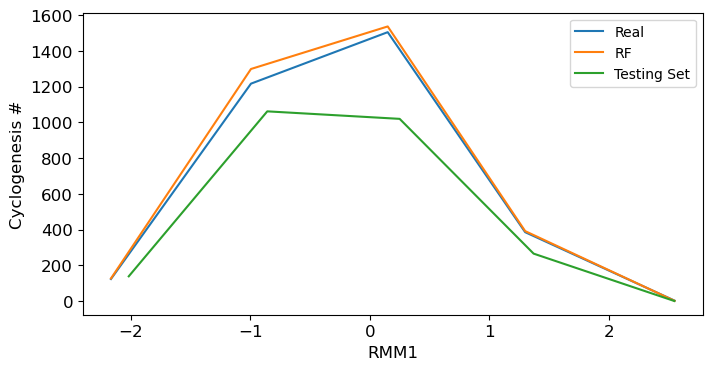

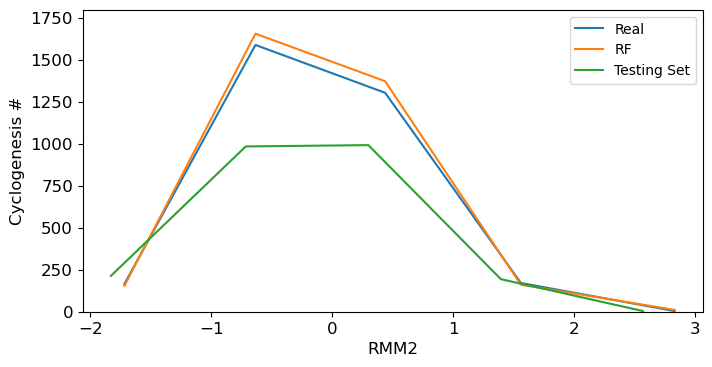

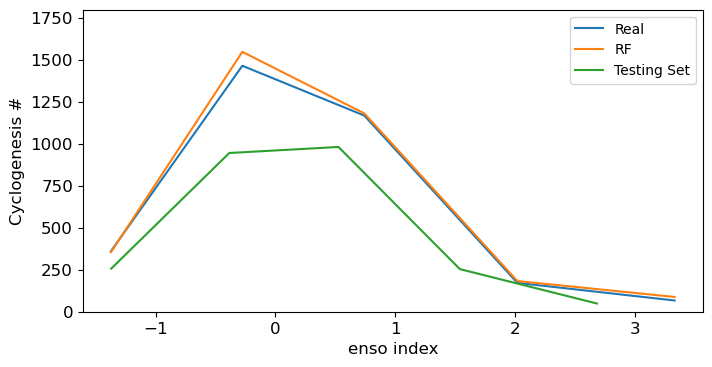

In [103]:
# fig, axes = plt.subplots(ncols=3, figsize=(12,4))
# plt.sca(axes[0])
plt.figure(figsize = [8,4])
plt.plot(rmm1_chunks, rmm1_chunks_cyclogen, label = 'Real')
plt.plot(rmm1_chunks, rmm1_chunks_rf, label = 'RF')
plt.plot(rmm1_chunks_testing, rmm1_chunks_rf_testing, label = 'Testing Set')
plt.xlabel('RMM1')
plt.ylabel('Cyclogenesis #')
# plt.ylim([-0.01,1800])
plt.legend()
plt.show()
# plt.sca(axes[1])
plt.figure(figsize = [8,4])
plt.plot(rmm2_chunks, rmm2_chunks_cyclogen, label = 'Real')
plt.plot(rmm2_chunks, rmm2_chunks_rf, label = 'RF')
plt.plot(rmm2_chunks_testing, rmm2_chunks_rf_testing, label = 'Testing Set')
plt.xlabel('RMM2')
plt.ylabel('Cyclogenesis #')
plt.ylim([-0.01,1800])
plt.legend()
plt.show()
# plt.sca(axes[2])
plt.figure(figsize = [8,4])
plt.plot(enso_chunks, enso_chunks_cyclogen, label = 'Real')
plt.plot(enso_chunks, enso_chunks_rf, label = 'RF')
plt.plot(enso_chunks_testing, enso_chunks_rf_testing, label = 'Testing Set')
plt.xlabel('enso index')
plt.ylabel('Cyclogenesis #')
plt.ylim([-0.01,1800])
plt.legend()
plt.show()

In [104]:
rmm1_chunks_cyclogen_f = np.zeros(len(rmm1_chunks))

rmm1_chunks_rf_f = np.zeros(len(rmm1_chunks))

rmm1_chunks_cyclogen_f_testing = np.zeros(len(rmm1_chunks_testing))

rmm1_chunks_rf_f_testing = np.zeros(len(rmm1_chunks_testing))


rmm2_chunks_cyclogen_f = np.zeros(len(rmm2_chunks))

rmm2_chunks_rf_f = np.zeros(len(rmm2_chunks))

rmm2_chunks_rf_f_testing = np.zeros(len(rmm2_chunks))


enso_chunks_cyclogen_f = np.zeros(len(enso_chunks))

enso_chunks_rf_f = np.zeros(len(enso_chunks))

enso_chunks_rf_f_testing = np.zeros(len(enso_chunks_testing))

In [105]:
for f in range(0,len(rmm1_chunks)):
    rmm1_chunks_cyclogen_f[f] = rmm1_chunks_cyclogen[f]/rmm1_chunks_days[f]
    rmm1_chunks_rf_f[f] = rmm1_chunks_rf[f]/rmm1_chunks_days[f]
    rmm1_chunks_rf_f_testing[f] = rmm1_chunks_rf_testing[f]/rmm1_chunks_days_testing[f]
       
    
for f in range(0,len(rmm2_chunks)):
    rmm2_chunks_cyclogen_f[f] = rmm2_chunks_cyclogen[f]/rmm2_chunks_days[f]
    rmm2_chunks_rf_f[f] = rmm2_chunks_rf[f]/rmm2_chunks_days[f]
    rmm2_chunks_rf_f_testing[f] = rmm2_chunks_rf_testing[f]/rmm2_chunks_days_testing[f]
    

for f in range(0,len(enso_chunks)):
    enso_chunks_cyclogen_f[f] = enso_chunks_cyclogen[f]/enso_chunks_days[f]
    enso_chunks_rf_f[f] = enso_chunks_rf[f]/enso_chunks_days[f]
    enso_chunks_rf_f_testing[f] = enso_chunks_rf_testing[f]/enso_chunks_days_testing[f]

In [106]:
enso_chunks_rf_f_testing

array([0.4015625 , 0.39090909, 0.37783763, 0.33421053, 0.35      ])

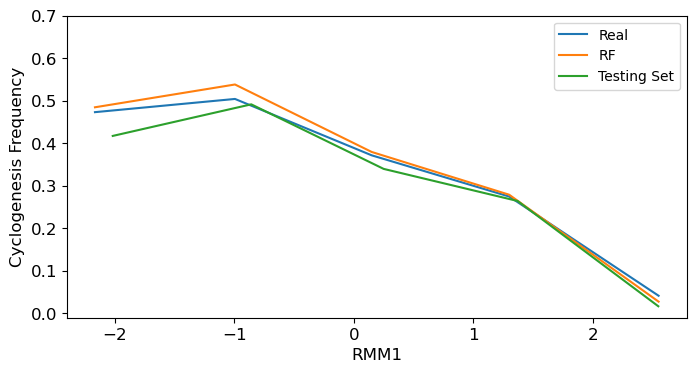

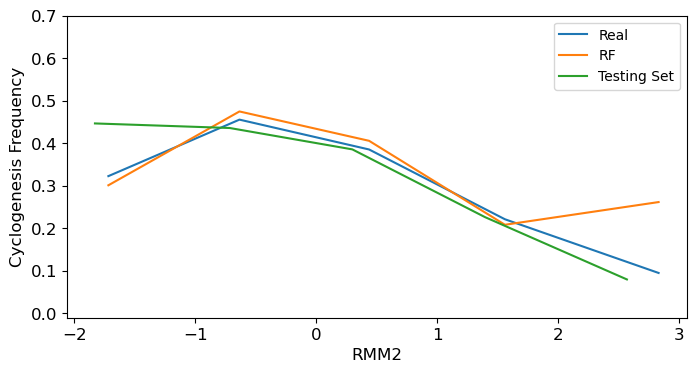

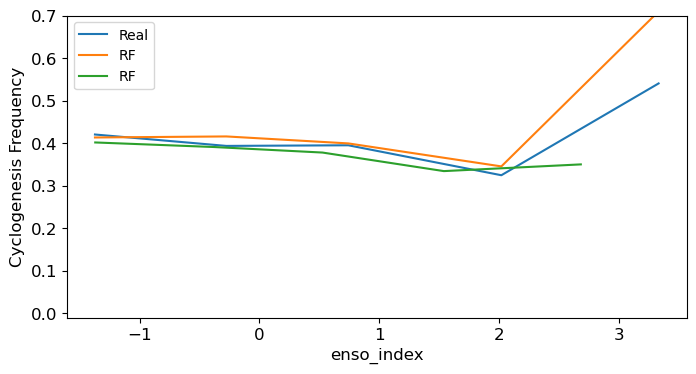

In [107]:
plt.figure(figsize = [8,4])
plt.plot(rmm1_chunks, rmm1_chunks_cyclogen_f, label = 'Real')
plt.plot(rmm1_chunks, rmm1_chunks_rf_f, label = 'RF')
plt.plot(rmm1_chunks_testing, rmm1_chunks_rf_f_testing, label = 'Testing Set')
plt.xlabel('RMM1')
plt.ylabel('Cyclogenesis Frequency')
plt.ylim([-.01,.7])
plt.legend()
plt.show()
plt.figure(figsize = [8,4])
plt.plot(rmm2_chunks, rmm2_chunks_cyclogen_f, label = 'Real')
plt.plot(rmm2_chunks, rmm2_chunks_rf_f, label = 'RF')
plt.plot(rmm2_chunks_testing, rmm2_chunks_rf_f_testing, label = 'Testing Set')
plt.xlabel('RMM2')
plt.ylabel('Cyclogenesis Frequency')
plt.ylim([-.01,.7])
plt.legend()
plt.show()
plt.figure(figsize = [8,4])
plt.plot(enso_chunks, enso_chunks_cyclogen_f, label = 'Real')
plt.plot(enso_chunks, enso_chunks_rf_f, label = 'RF')
plt.plot(enso_chunks_testing, enso_chunks_rf_f_testing, label = 'RF')
plt.ylim([-.01,.7])
plt.xlabel('enso_index')
plt.ylabel('Cyclogenesis Frequency')
plt.legend()
plt.show()

In [108]:
num_chunks =((2019-1979))  # 6 chunks per year 

values_per_chunk = len(todos_x)/num_chunks

num_chunks, values_per_chunk

(40, 204.975)

In [109]:
steps = (np.round(np.arange(0,len(todos_x),values_per_chunk))).astype(int)
steps

array([   0,  205,  410,  615,  820, 1025, 1230, 1435, 1640, 1845, 2050,
       2255, 2460, 2665, 2870, 3075, 3280, 3485, 3690, 3895, 4100, 4304,
       4509, 4714, 4919, 5124, 5329, 5534, 5739, 5944, 6149, 6354, 6559,
       6764, 6969, 7174, 7379, 7584, 7789, 7994])

In [110]:
chunked_RMM1 = np.zeros([num_chunks])
chunked_RMM2 = np.zeros([num_chunks])
chunked_enso = np.zeros([num_chunks])
chunked_rf_cyclogen = np.zeros([num_chunks])
chunked_cyclogen = np.zeros([num_chunks])
chunked_date = np.zeros([num_chunks])


contador = 0 
for chunk in steps[:]:
#     print(chunk,chunk+np.round(values_per_chunk).astype(int))
    chunked_RMM1[contador] = np.mean(todos_x['RMM1'][chunk:(chunk+np.round(values_per_chunk).astype(int))])
    chunked_RMM2[contador] = np.mean(todos_x['RMM2'][chunk:(chunk+np.round(values_per_chunk).astype(int))])
    chunked_enso[contador] = np.mean(todos_x['enso_index'][chunk:(chunk+np.round(values_per_chunk).astype(int))])
    chunked_rf_cyclogen[contador] = np.mean(todos_x['rf_classes'][chunk:(chunk+np.round(values_per_chunk).astype(int))])
    chunked_cyclogen[contador] = np.mean(todos_x['storms_01'][chunk:(chunk+np.round(values_per_chunk).astype(int))])
    chunked_date[contador] = todos_x['year'][chunk]
    

    
    contador += 1

chunked_RMM1.shape

KeyError: 'year'

In [ ]:
# plt.figure(figsize=[12,8])
# plt.plot(chunked_RMM1,chunked_cyclogen,'o', label = 'real')
# plt.plot(chunked_RMM1,chunked_rf_cyclogen,'o', label = 'RF')
# plt.xlabel('RMM1')
# plt.ylabel('Cyclogenesis Frequency')
# plt.xlim([-.5,.5])
# plt.legend()
# plt.show()
# plt.plot(chunked_RMM2, chunked_cyclogen)
# plt.plot(chunked_enso,chunked_cyclogen)

In [ ]:
# plt.figure(figsize=[12,8])
# plt.plot(chunked_RMM2,chunked_cyclogen,'o', label = 'real')
# plt.plot(chunked_RMM2,chunked_rf_cyclogen,'o', label = 'RF')
# plt.xlabel('RMM2')
# plt.ylabel('Cyclogenesis Frequency')
# plt.xlim([-.5,.5])
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=[12,8])
# plt.plot(chunked_enso,chunked_cyclogen,'o', label = 'real')
# plt.plot(chunked_enso,chunked_rf_cyclogen,'o', label = 'RF')
# plt.axvline()
# plt.vlines(x = 0.5,ymin=0,ymax=1,linestyles='dashed')
# plt.vlines(x = -0.5,ymin=0,ymax=1, linestyles='dashed')
# plt.xlabel('ENSO Index')
# plt.ylabel('Cyclogenesis Frequency')
# plt.xlim([-2.8,2.8])
# plt.ylim([.2,.65])
# plt.legend()
# plt.show()